In [1]:
# importing all relevant python libraries
import warnings
warnings.filterwarnings("ignore")

import math

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RandomizedSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix

import pickle

In [2]:
# define a function to find the number and percentage of missing values in a dataframe
def get_missing_values_count_and_percentage(dataframe):
  num = 0
  for column in dataframe.columns:
    count = dataframe[column].isnull().sum()
    percentage = count/dataframe.shape[0]*100
    if percentage > 0:
      num += 1
      print(f"{column}: {count}({round(percentage, 2)})%")
  if num == 0:
    print("No missing values in the dataframe")

In [3]:
# define a function to calculate the vif of all features
# returns a dataframe
def calculate_vif_of_all_features(dataframe):
  temp_df = pd.DataFrame()
  temp_df['Feature'] = dataframe.columns
  temp_df['VIF'] = [variance_inflation_factor(dataframe.values, column_index) for column_index in range(dataframe.shape[1])]

  return temp_df

In [4]:
# define a function to calculate the upper and lower outlier boundary
# returns a tuple (upper_outlier_bound, lower_outlier_bound)
def get_outlier_boundaries(dataframe, column):
  percentile_25 = np.nanpercentile(dataframe[column],25)
  percentile_75 = np.nanpercentile(dataframe[column],75)
  iqr = (percentile_75 - percentile_25)
  upper_outlier_bound = percentile_75 + 1.5*iqr
  lower_outlier_bound = percentile_25 - 1.5*iqr

  return (upper_outlier_bound, lower_outlier_bound)

# define a function to calculate the number and percentage of outliers in a column
# returns a tuple (count, percentage)
def get_outlier_count_and_percentage(dataframe, column):
  # print(dataframe.shape[0])
  upper_outlier_bound, lower_outlier_bound = get_outlier_boundaries(dataframe, column)

  count = 0
  for value in dataframe[column]:
    if value > upper_outlier_bound or value < lower_outlier_bound:
      count += 1
  percentage = round(count/dataframe.shape[0]*100, 2)

  return (count, percentage)

In [5]:
# define a function to calculate metrics
# returns a dictionary
def calculate_model_metrics(trained_model, X_train, y_train, X_test, y_test):

  # print best parameter values and score
  print("The best parameters: ")
  for key, value in trained_model.best_params_.items():
    print(f"{key}={value}")
  print(f"\nBest score: {trained_model.best_score_}\n")

  # predict train and test data
  y_train_pred = trained_model.predict(X_train)
  y_test_pred= trained_model.predict(X_test)

  # probabilities of train and test data
  train_prob = trained_model.predict_proba(X_train)
  test_prob = trained_model.predict_proba(X_test)

  metrics_dict = {}

  metrics_dict['Train_Accuracy'] = accuracy_score(y_train, y_train_pred) * 100
  metrics_dict['Test_Accuracy'] = accuracy_score(y_test, y_test_pred) * 100
  metrics_dict['Train_Precision'] = precision_score(y_train, y_train_pred, average='weighted') * 100
  metrics_dict['Test_Precision'] = precision_score(y_test, y_test_pred, average='weighted') * 100
  metrics_dict['Train_Recall'] = recall_score(y_train, y_train_pred, average='weighted') * 100
  metrics_dict['Test_Recall'] = recall_score(y_test, y_test_pred, average='weighted') * 100
  metrics_dict['Train_F1_Score'] = f1_score(y_train, y_train_pred, average='weighted') * 100
  metrics_dict['Test_F1_Score'] = f1_score(y_test, y_test_pred, average='weighted') * 100
  metrics_dict['Train_ROC_AUC'] = roc_auc_score(y_train, train_prob, average='weighted', multi_class='ovr')
  metrics_dict['Test_ROC_AUC'] = roc_auc_score(y_test, test_prob, average='weighted', multi_class='ovr')

  # print the results of model evaluation
  print(f"Training Data")
  print(f"Accuracy  : {round(metrics_dict['Train_Accuracy'], 6)} %")
  print(f"Precision : {round(metrics_dict['Train_Precision'], 6)} %")
  print(f"Recall    : {round(metrics_dict['Train_Recall'], 6)} %")
  print(f"F1 Score  : {round(metrics_dict['Train_F1_Score'], 6)} %")
  print(f"ROC AUC   : {round(metrics_dict['Train_ROC_AUC'], 6)}\n")
  print(f"Testing Data")
  print(f"Accuracy  : {round(metrics_dict['Test_Accuracy'], 6)} %")
  print(f"Precision : {round(metrics_dict['Test_Precision'], 6)} %")
  print(f"Recall    : {round(metrics_dict['Test_Recall'], 6)} %")
  print(f"F1 Score  : {round(metrics_dict['Test_F1_Score'], 6)} %")
  print(f"ROC AUC   : {round(metrics_dict['Test_ROC_AUC'], 6)}\n")

  # plot ROC curve
  fpr = {}
  tpr = {}
  thresh ={}
  no_of_class=3
  for i in range(no_of_class):
      fpr[i], tpr[i], thresh[i] = metrics.roc_curve(y_test, test_prob[:,i], pos_label=i)
  plt.figure(figsize=(12, 6))
  plt.plot(fpr[0], tpr[0], linestyle='--',color='blue', label='Ignored vs Others'+" AUC="+str(round(metrics_dict['Test_ROC_AUC'], 6)))
  plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Read vs Others'+" AUC="+str(round(metrics_dict['Test_ROC_AUC'], 6)))
  plt.plot(fpr[2], tpr[2], linestyle='--',color='orange', label='Acknowledged vs Others'+" AUC="+str(round(metrics_dict['Test_ROC_AUC'], 6)))
  plt.title("ROC curve")
  plt.ylabel("True Positive Rate")
  plt.xlabel("False Positive Rate")
  plt.legend(loc=4)
  plt.show()

  # plot confusion matrix
  cf_matrix = confusion_matrix(y_test_pred, y_test)
  print("\n")
  sns.heatmap(cf_matrix, annot=True, cmap='Blues')

  return metrics_dict

In [6]:
# defining a function to generate a count plot
def generate_count_plot(data):
  """
  Function to generate a count plot
  """
  plt.rcParams["figure.figsize"] = [7.50, 3.50]
  plt.rcParams["figure.autolayout"] = True
  fig, ax = plt.subplots()
  data.value_counts().plot(ax=ax, kind='bar')
  plt.show()

In [7]:
# define a function to generate horizontal box plot
# prints a box plot
def generate_horizontal_box_plot(dataframe, x_feature, y_feature=None):
  sns.set_theme(rc={'figure.figsize': (8,4)},style='whitegrid',palette='muted')
  if y_feature != None:
    ax = sns.boxplot(x=dataframe[x_feature], y=dataframe[y_feature])
  else:
    ax = sns.boxplot(x=dataframe[x_feature], y=None)
  ax.grid(False)

# define a function to generate vertical box plot
# prints a box plot
def generate_vertical_box_plot(dataframe, y_feature, x_feature=None):
  sns.set_theme(rc={'figure.figsize': (4,8)},style='whitegrid',palette='muted')
  if x_feature != None:
    ax = sns.boxplot(y=dataframe[y_feature], x=dataframe[x_feature])
  else:
    ax = sns.boxplot(y=dataframe[y_feature], x=None)
  ax.grid(False)

In [8]:
# get count of each unique value from a particular column
# and output its as a dataframe
def get_count_from_column(df, column_label):
  df_grpd = df[column_label].value_counts()
  df_grpd = pd.DataFrame({'index':df_grpd.index, 'count':df_grpd.values})
  return df_grpd

# add value to the top of each bar
def add_value_label(x_list,y_list):
    for i in range(1, len(x_list)+1):
        plt.text(i-1,y_list[i-1],y_list[i-1], ha="center", fontweight='bold')

# plot bar graph from grouped data
def plot_bar_graph_from_column(df, column_label):
  df_grpd = get_count_from_column(df, column_label)

  df_grpd.plot(x='index', y='count', kind='bar', figsize=(3*df_grpd.shape[0], 6))
  add_value_label(df_grpd['index'].tolist(), df_grpd['count'].tolist())
  plt.xlabel(column_label)
  plt.ylabel("Count")
  plt.xticks(rotation='horizontal')
  plt.gca().legend_.remove()
  plt.show()

In [9]:
# generate density plots of a feature in a dataframe
# prints a density plot
def density_plot_of_a_feature(dataframe, feature):
  plt.figure(figsize=(8, 6))
  sns.distplot(dataframe[feature])
  plt.show()

# generate density plots of all features in a dataframe
# prints a density plots
def density_plot_of_all_features(dataframe):
  columns = dataframe.describe().columns.tolist()

  columns_num = 3
  rows_num = math.ceil(len(columns)/columns_num)
  fig, axes = plt.subplots(rows_num, columns_num, figsize=(10*columns_num, 8*rows_num))

  row = -1
  column = columns_num - 1
  for feature in columns:
    if column == (columns_num - 1):
      row += 1
      column = 0
    else:
      column += 1
    sns.distplot(ax=axes[row, column], a=dataframe[feature])
    axes[row, column].set_title(f"{feature} Distribution")

  if len(columns) % columns_num != 0:
    for column_num in range(column + 1, columns_num):
      fig.delaxes(axes[rows_num - 1][column_num])

In [10]:
# define a function to plot a stacked bar to show percentage of a feature in a grouped parameter
# so that it can be used in the later stages also

# get the count of unique values in secondary column
# segmented by each unique value in primary column
def get_count_of_unique_values(df, pri_column_label, sec_column_label):
  # finding unique values in secondary column for grouping
  values = sorted([x for x in df[sec_column_label].unique() if str(x) != 'nan'])

  # creating a list of dataframes that gives the value of each unique value in primary column
  # a dataframe is created for each unique value in secondary column
  list_of_counts_df = [df[df[sec_column_label] == value].groupby(pri_column_label)[sec_column_label].count().reset_index(name=f'{value}')
                       for value in values]

  # merge all dataframes into one dataframe
  df_merged = list_of_counts_df[0]
  for i in range(1, len(list_of_counts_df)):
    df_merged = pd.merge(df_merged, list_of_counts_df[i], how='inner', on=pri_column_label)

  return df_merged

# plotting a stacked bar graph to represent the count of unique values in secondary column
# segmented by each unique value in primary column
def stacked_bar_graph_with_count(df, pri_column_label, sec_column_label):
   # computing the percentage of unique values in secondary column contributed by each unique value in primary column
  df_merged = get_count_of_unique_values(df, pri_column_label, sec_column_label)

  ax = df_merged.plot(x=pri_column_label, kind='bar', stacked=True, figsize=(12,6))
  for bar in ax.patches:
    height = bar.get_height()
    width = bar.get_width()
    x = bar.get_x()
    y = bar.get_y()
    label_text = str(height)
    label_x = x + width / 2
    label_y = y + height / 2
    ax.text(label_x, label_y, label_text, ha='center', va='center', fontweight='bold')
  plt.xticks(rotation='horizontal')
  plt.title(f"Percentage of different categories of {sec_column_label} across each {pri_column_label} category")
  plt.show()

# get the % of unique values in secondary column
# segmented by each unique value in primary column
def get_percentage_of_unique_values(df, pri_column_label, sec_column_label):
  # finding unique values in secondary column for grouping
  values = [x for x in df[sec_column_label].unique() if str(x) != 'nan']

  # creating a dataframe that gives the count of each unique value in primary column
  df_merged = get_count_of_unique_values(df, pri_column_label, sec_column_label)

  # computing the percentage of unique values in secondary column contributed by each unique value in primary column
  df_merged['total_count'] = df_merged.sum(axis=1, numeric_only=True)
  for value in values:
    df_merged[f'{value}'] = round(df_merged[f'{value}'] / df_merged['total_count'] * 100)
  df_merged.drop('total_count', axis=1, inplace=True)

  return df_merged

# plotting a stacked bar graph to represent the % of unique values in secondary column
# segmented by each unique value in primary column
def stacked_bar_graph_with_percentage(df, pri_column_label, sec_column_label):
   # computing the percentage of unique values in secondary column contributed by each unique value in primary column
  df_merged = get_percentage_of_unique_values(df, pri_column_label, sec_column_label)

  ax = df_merged.plot(x=pri_column_label, kind='bar', stacked=True, figsize=(12,6))
  for bar in ax.patches:
    height = bar.get_height()
    width = bar.get_width()
    x = bar.get_x()
    y = bar.get_y()
    label_text = str(height) + " %"
    label_x = x + width / 2
    label_y = y + height / 2
    ax.text(label_x, label_y, label_text, ha='center', va='center', fontweight='bold')
  plt.xticks(rotation='horizontal')
  plt.title(f"Percentage of different categories of {sec_column_label} across each {pri_column_label} category")
  plt.show()

In [11]:
# define a function to plot bar graph with three features
# prints a bar graph
def plot_bar_graph_with_three_features(dataframe, x_feature, y_feature, z_feature, y_label):
  plt.figure(figsize=(26, 6))

  X = dataframe[x_feature].tolist()
  Y = dataframe[y_feature].tolist()
  Z = dataframe[z_feature].tolist()

  X_axis_length = np.arange(len(X))

  plt.bar(X_axis_length - 0.2, Y, 0.4, label = y_feature)
  plt.bar(X_axis_length + 0.2, Z, 0.4, label = z_feature)

  min_limit = 0.9 * min(dataframe[y_feature].min(), dataframe[z_feature].min())
  max_limit = 1.1 * max(dataframe[y_feature].max(), dataframe[z_feature].max())
  plt.ylim(min_limit, max_limit)

  plt.xticks(X_axis_length, X)
  plt.xlabel(x_feature)
  plt.ylabel(y_label)
  plt.legend()
  plt.show()

# Reading Data

In [12]:
opened_df=pd.read_csv("email_opened_table.csv")
opened_df.head()

,email_id
0,284534
1,609056
2,220820
3,905936
4,164034


In [13]:
campaign_df=pd.read_csv("email_table.csv")
clicked_df=pd.read_csv("link_clicked_table.csv")

In [14]:
campaign_df['opened'] = campaign_df['email_id'].isin(opened_df['email_id']).astype(int)
campaign_df['clicked'] = campaign_df['email_id'].isin(clicked_df['email_id']).astype(int)

# Data Inspection

The given data contains information regarding the mails sent as a part of Gmail-based e-mail marketing campaign. Lets first examine the data present in it.

In [15]:
# exploring the head of the dataframe
campaign_df.head()

,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases,opened,clicked
0,85120,short_email,personalized,2,Sunday,US,5,0,0
1,966622,long_email,personalized,12,Sunday,UK,2,1,1
2,777221,long_email,personalized,11,Wednesday,US,2,0,0
3,493711,short_email,generic,6,Monday,UK,1,0,0
4,106887,long_email,generic,14,Monday,US,6,0,0


In [16]:
# exploring the tail of the dataframe
campaign_df.tail()

,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases,opened,clicked
99995,803504,short_email,personalized,4,Monday,US,5,0,0
99996,899722,long_email,personalized,7,Saturday,US,1,0,0
99997,449610,long_email,personalized,11,Saturday,UK,6,0,0
99998,72497,short_email,generic,10,Monday,UK,0,0,0
99999,348333,long_email,personalized,8,Sunday,UK,1,1,1


In [17]:
# looking into a brief summary of dataframe
campaign_df.describe()

,email_id,hour,user_past_purchases,opened,clicked
count,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000
mean,498690.196160,9.059300,3.87845,0.103450,0.021190
std,289230.727534,4.439637,3.19611,0.304547,0.144018
min,8.000000,1.000000,0.00000,0.000000,0.000000
25%,246708.250000,6.000000,1.00000,0.000000,0.000000
50%,498447.000000,9.000000,3.00000,0.000000,0.000000
75%,749942.750000,12.000000,6.00000,0.000000,0.000000
max,999998.000000,24.000000,22.00000,1.000000,1.000000


In [18]:
# total number of rows in the dataset
num_of_rows = campaign_df.shape[0]
print(f"Total no. of rows: {num_of_rows}")

# number of duplicate rows
num_of_dup_rows = campaign_df[campaign_df.duplicated()].shape[0]
print(f"No. of duplicate rows: {num_of_dup_rows}")

Total no. of rows: 100000
No. of duplicate rows: 0


*   The dataframe contains 100000 rows of data and has zero duplicate rows.

In [19]:
# exploring the columns of the dataframe
campaign_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   email_id             100000 non-null  int64 
 1   email_text           100000 non-null  object
 2   email_version        100000 non-null  object
 3   hour                 100000 non-null  int64 
 4   weekday              100000 non-null  object
 5   user_country         100000 non-null  object
 6   user_past_purchases  100000 non-null  int64 
 7   opened               100000 non-null  int32 
 8   clicked              100000 non-null  int32 
dtypes: int32(2), int64(3), object(4)
memory usage: 6.1+ MB


*   The dataframe contains 9 columns.
*   no columns have missing values.
*   Three columns require conversion of datatypes.

In [20]:
# unique values in each column of the dataframe
print(campaign_df.apply(lambda col: col.unique()))

email_id               [85120, 966622, 777221, 493711, 106887, 684440...
email_text                                     [short_email, long_email]
email_version                                    [personalized, generic]
hour                   [2, 12, 11, 6, 14, 9, 8, 5, 23, 7, 10, 3, 4, 1...
weekday                [Sunday, Wednesday, Monday, Saturday, Friday, ...
user_country                                            [US, UK, FR, ES]
user_past_purchases    [5, 2, 1, 6, 3, 8, 4, 9, 0, 11, 10, 7, 13, 12,...
opened                                                            [0, 1]
clicked                                                           [0, 1]
dtype: object


In [21]:
# finding the number and percentage of missing values in the data
get_missing_values_count_and_percentage(campaign_df)

No missing values in the dataframe


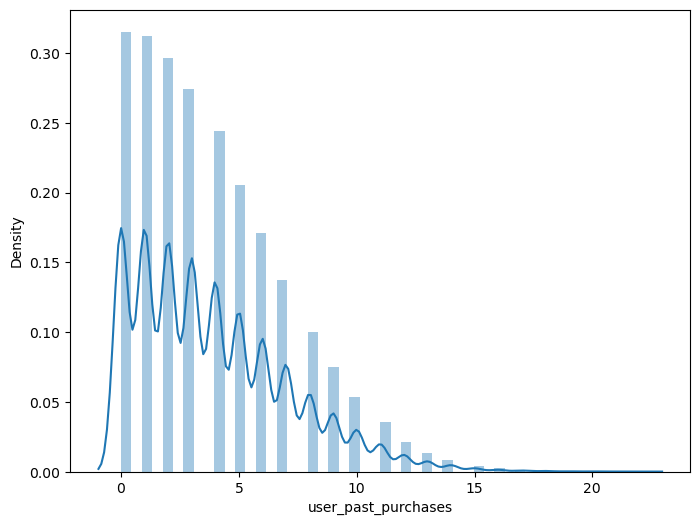

In [22]:
# create a density plot to show the distribution of values in user_past_purchases

density_plot_of_a_feature(campaign_df, 'user_past_purchases')

In [23]:
campaign_df

,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases,opened,clicked
0,85120,short_email,personalized,2,Sunday,US,5,0,0
1,966622,long_email,personalized,12,Sunday,UK,2,1,1
2,777221,long_email,personalized,11,Wednesday,US,2,0,0
3,493711,short_email,generic,6,Monday,UK,1,0,0
4,106887,long_email,generic,14,Monday,US,6,0,0
...,...,...,...,...,...,...,...,...,...
99995,803504,short_email,personalized,4,Monday,US,5,0,0
99996,899722,long_email,personalized,7,Saturday,US,1,0,0
99997,449610,long_email,personalized,11,Saturday,UK,6,0,0
99998,72497,short_email,generic,10,Monday,UK,0,0,0


<Axes: xlabel='user_past_purchases', ylabel='email_text'>

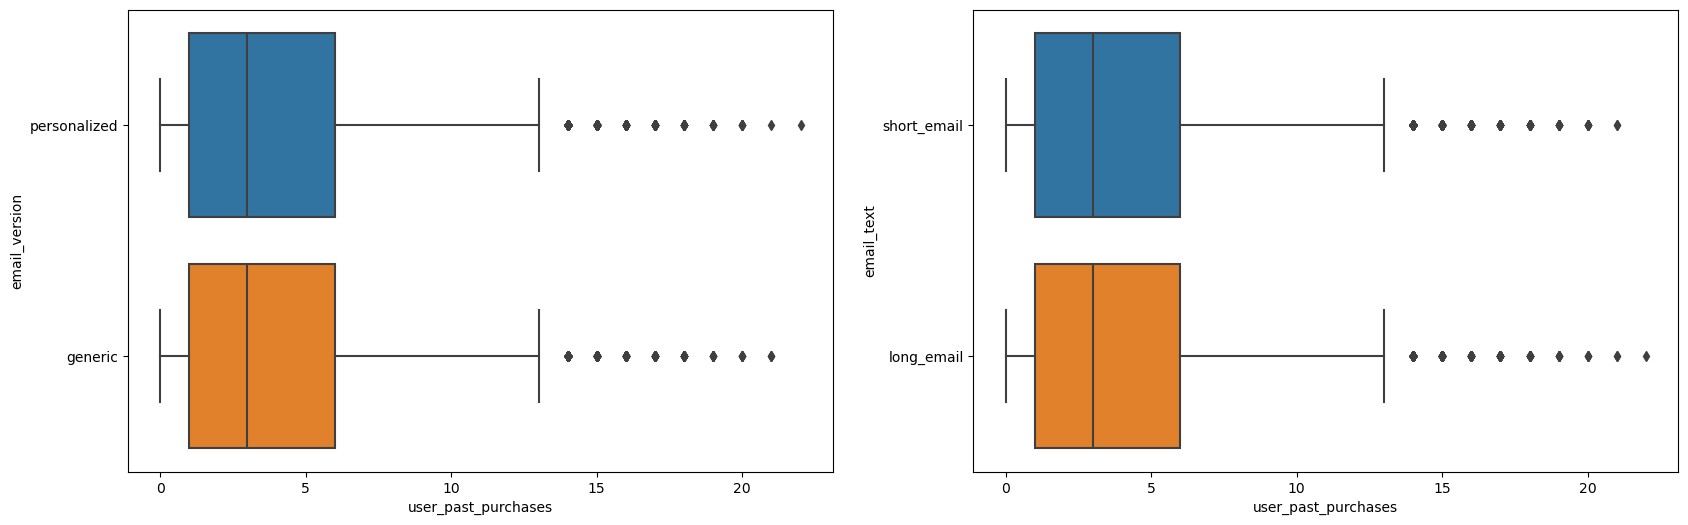

In [24]:
# generate box plots to show the distribution of user_past_purchases in each category of Email_Type and email_version

fig, axes = plt.subplots(1, 2, figsize=(20, 6))
sns.boxplot(ax=axes[0], data=campaign_df, x='user_past_purchases', y='email_version', orient='h')
sns.boxplot(ax=axes[1], data=campaign_df, x='user_past_purchases', y='email_text', orient='h')

Lets check its box plot to check for outliers.

Number of outliers: 778
Percentage of outliers: 0.78%


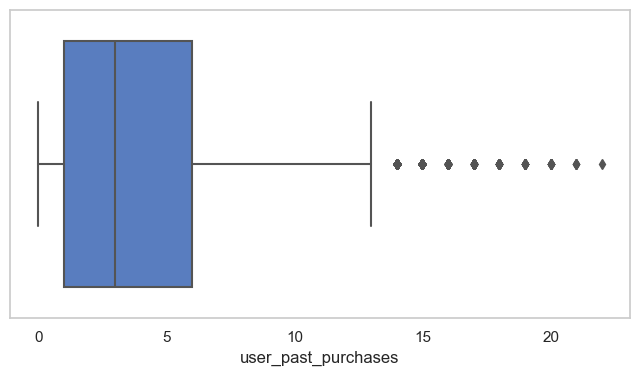

In [25]:
# create a box plot to show the distribution of values in user_past_purchases

generate_horizontal_box_plot(campaign_df, 'user_past_purchases')
outlier_count, outlier_percentage = get_outlier_count_and_percentage(campaign_df, 'user_past_purchases')
print(f"Number of outliers: {outlier_count}")
print(f"Percentage of outliers: {outlier_percentage}%")

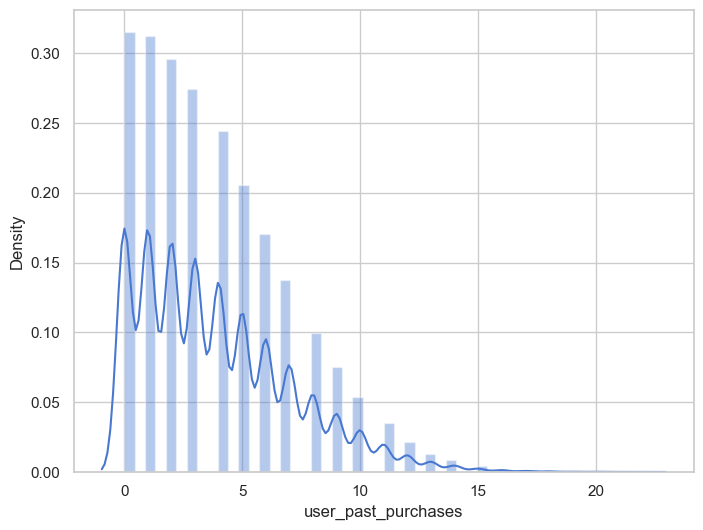

In [26]:

density_plot_of_a_feature(campaign_df, 'user_past_purchases')

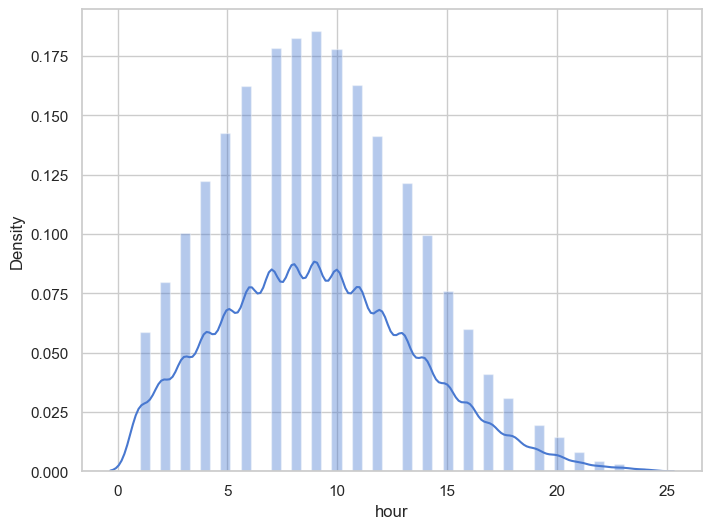

In [27]:
# create a density plot to show the distribution of values in hours

density_plot_of_a_feature(campaign_df, 'hour')

In [28]:
# number and percentage of missing values in the dataframe
get_missing_values_count_and_percentage(campaign_df)

No missing values in the dataframe


### Conversion of Column Datatype

In [29]:
# datatypes of columns in the dataframe
campaign_df.dtypes

email_id                int64
email_text             object
email_version          object
hour                    int64
weekday                object
user_country           object
user_past_purchases     int64
opened                  int32
clicked                 int32
dtype: object

In [30]:
campaign_df['email_id'].duplicated().sum()

0

In [31]:
# datatypes of columns in the dataframe
campaign_df.dtypes

email_id                int64
email_text             object
email_version          object
hour                    int64
weekday                object
user_country           object
user_past_purchases     int64
opened                  int32
clicked                 int32
dtype: object

In [32]:
#i assumed that  first you have to open the email then clicked on link it so those emails which are clicked by users also opened first


# 0 = ignored, 1 = opened, 2 = clicked
def engagement_level(row):
    if row['clicked'] == 1:
        return 2
    elif row['opened'] == 1:
        return 1
    else:
        return 0

campaign_df['engagement'] =campaign_df.apply(engagement_level, axis=1)
campaign_df=campaign_df.drop(['opened','clicked'],axis=1)


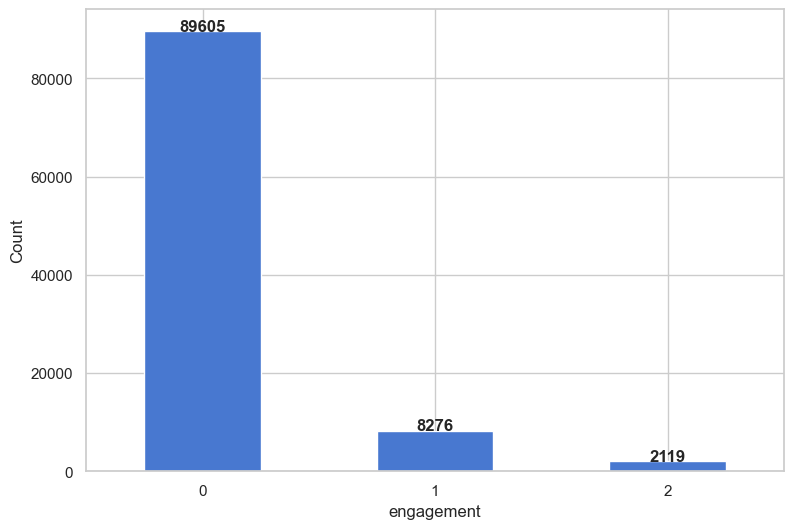

In [33]:
# plot bar graph to show the count of each category in engagement

plot_bar_graph_from_column(campaign_df, 'engagement')

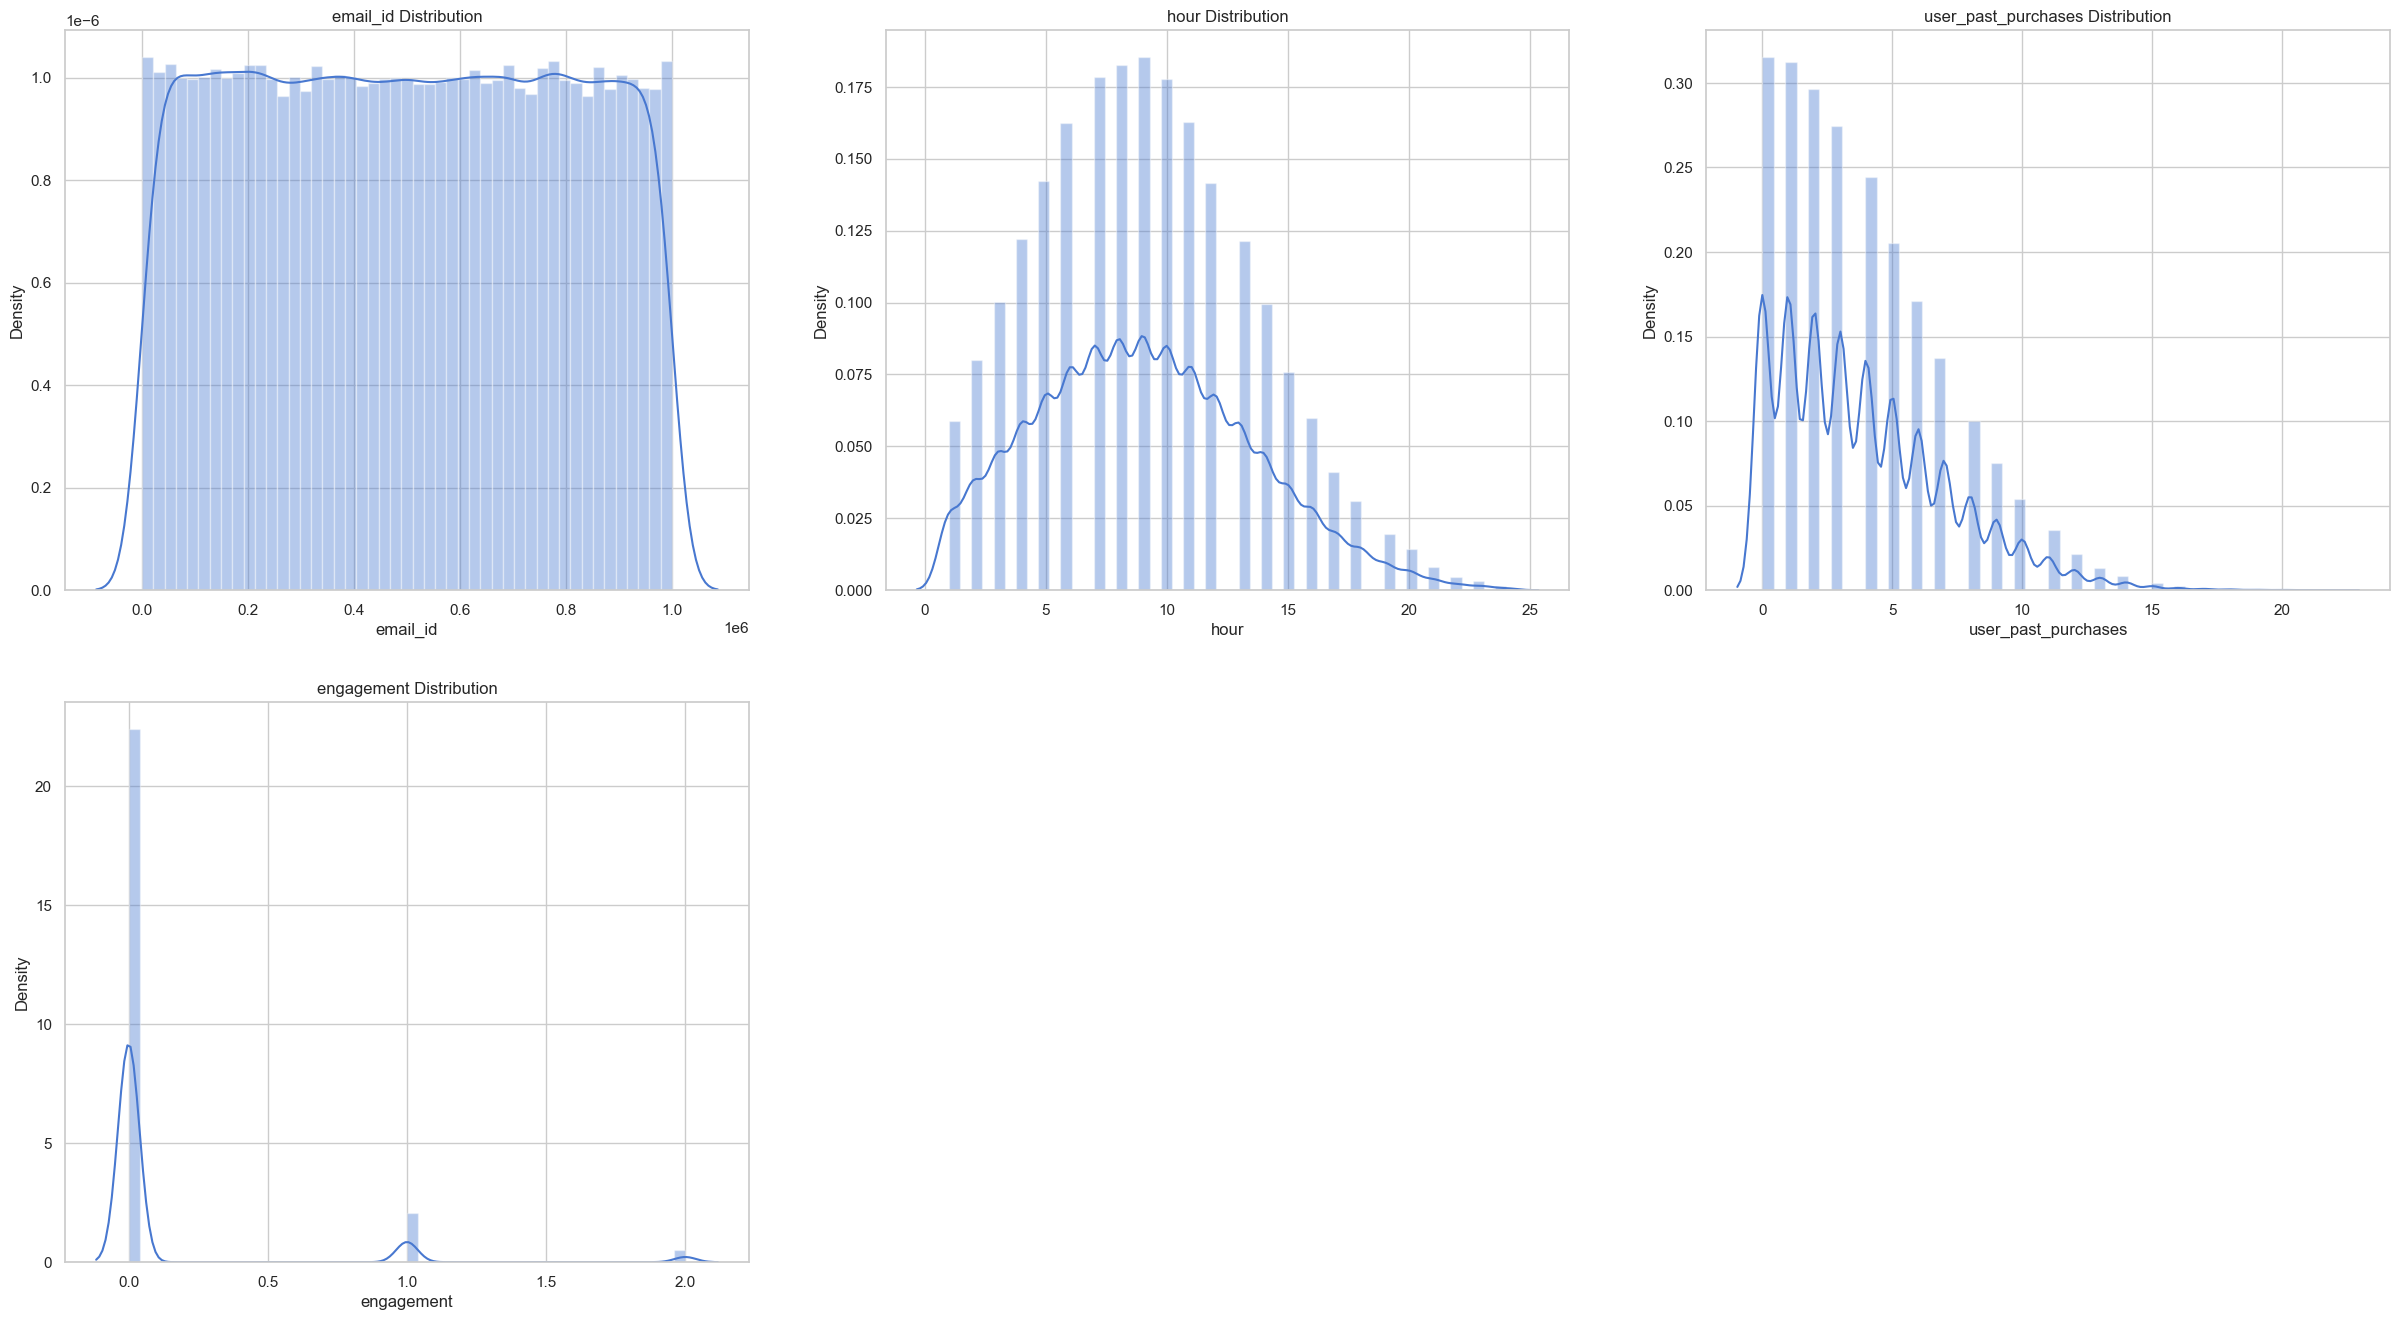

In [34]:
# plot the distribution of all features
density_plot_of_all_features(campaign_df)

In [35]:
campaign_df

,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases,engagement
0,85120,short_email,personalized,2,Sunday,US,5,0
1,966622,long_email,personalized,12,Sunday,UK,2,2
2,777221,long_email,personalized,11,Wednesday,US,2,0
3,493711,short_email,generic,6,Monday,UK,1,0
4,106887,long_email,generic,14,Monday,US,6,0
...,...,...,...,...,...,...,...,...
99995,803504,short_email,personalized,4,Monday,US,5,0
99996,899722,long_email,personalized,7,Saturday,US,1,0
99997,449610,long_email,personalized,11,Saturday,UK,6,0
99998,72497,short_email,generic,10,Monday,UK,0,0


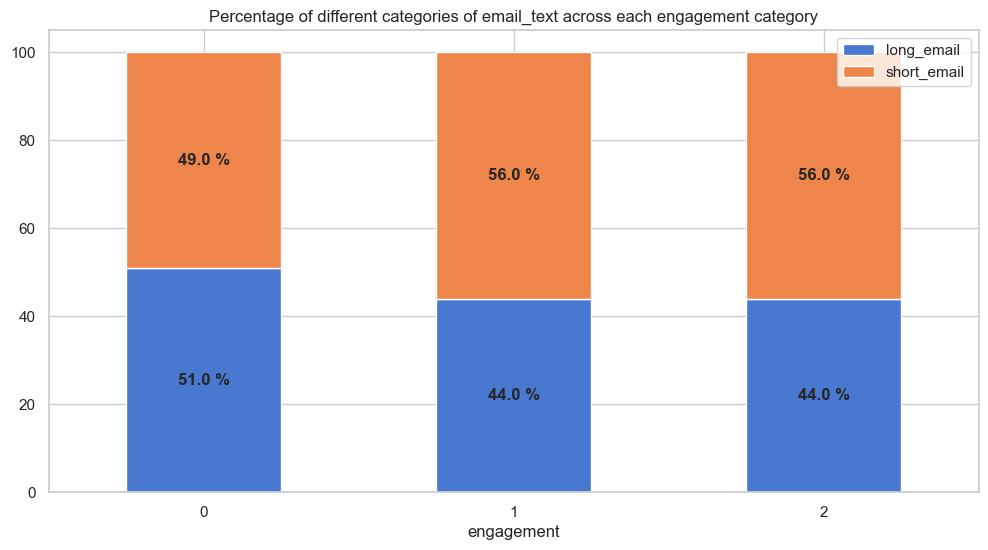

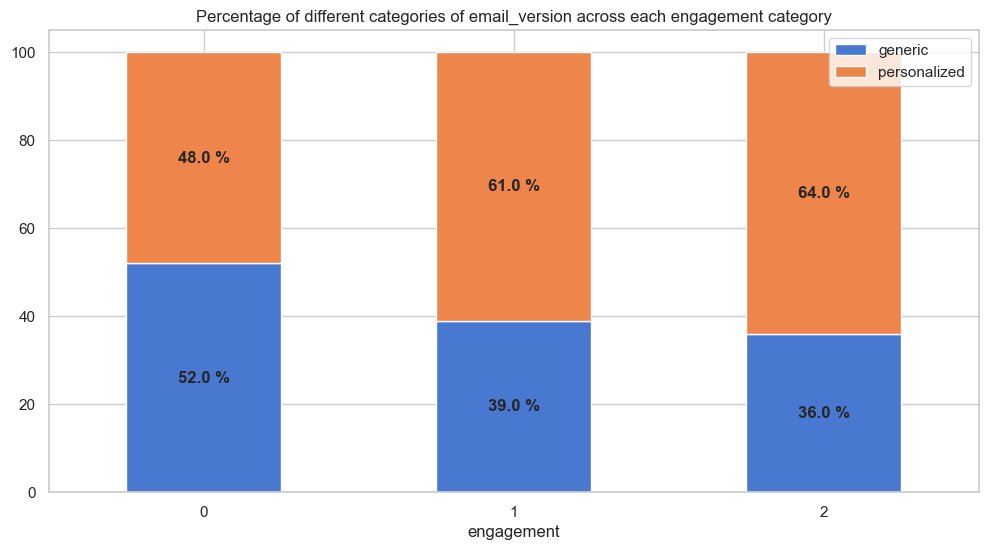

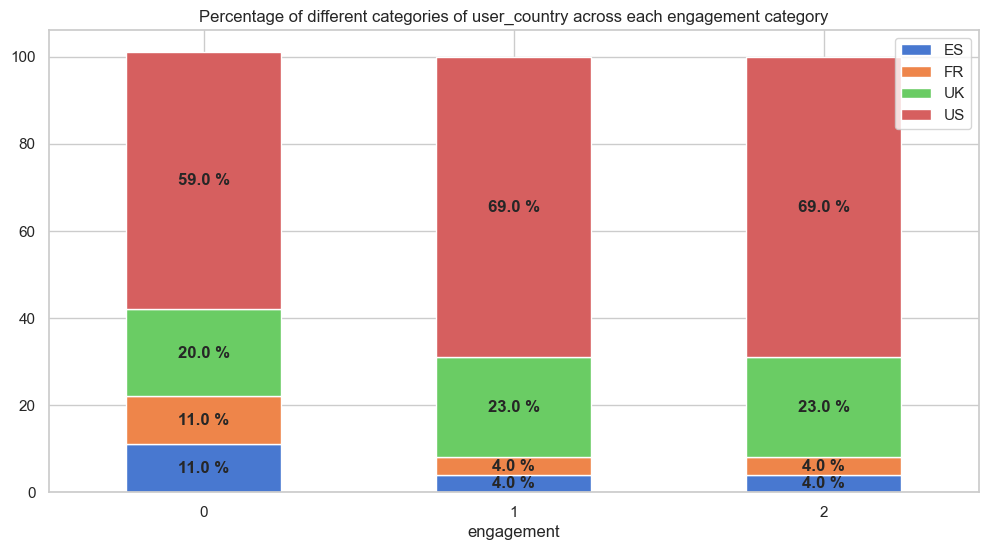

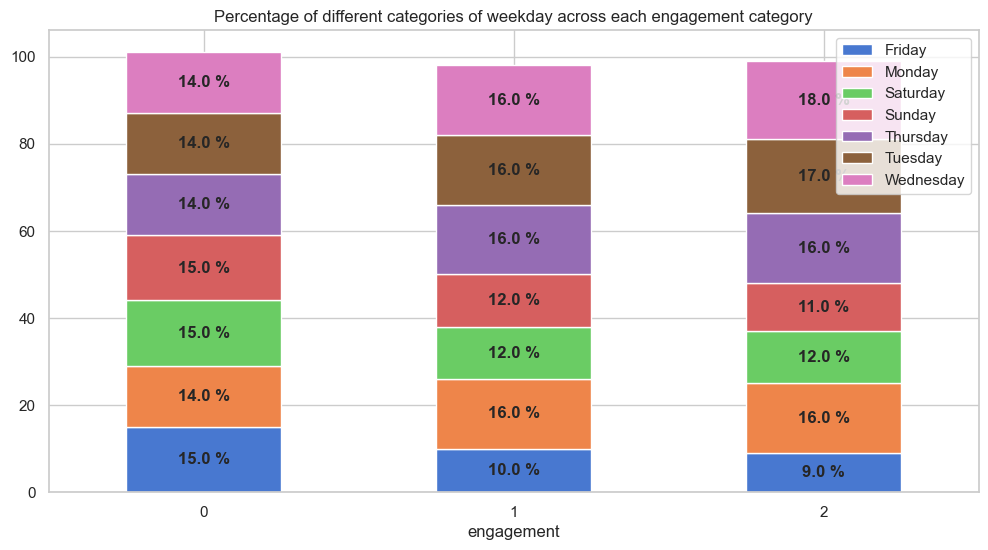

In [36]:
# plot stacked bar graphs to show the percentage of e-mails in each feature category for every engagement
categorical_features = ['email_text', 'email_version', 'user_country','weekday']

for feature in categorical_features:
  stacked_bar_graph_with_percentage(campaign_df, 'engagement', feature)

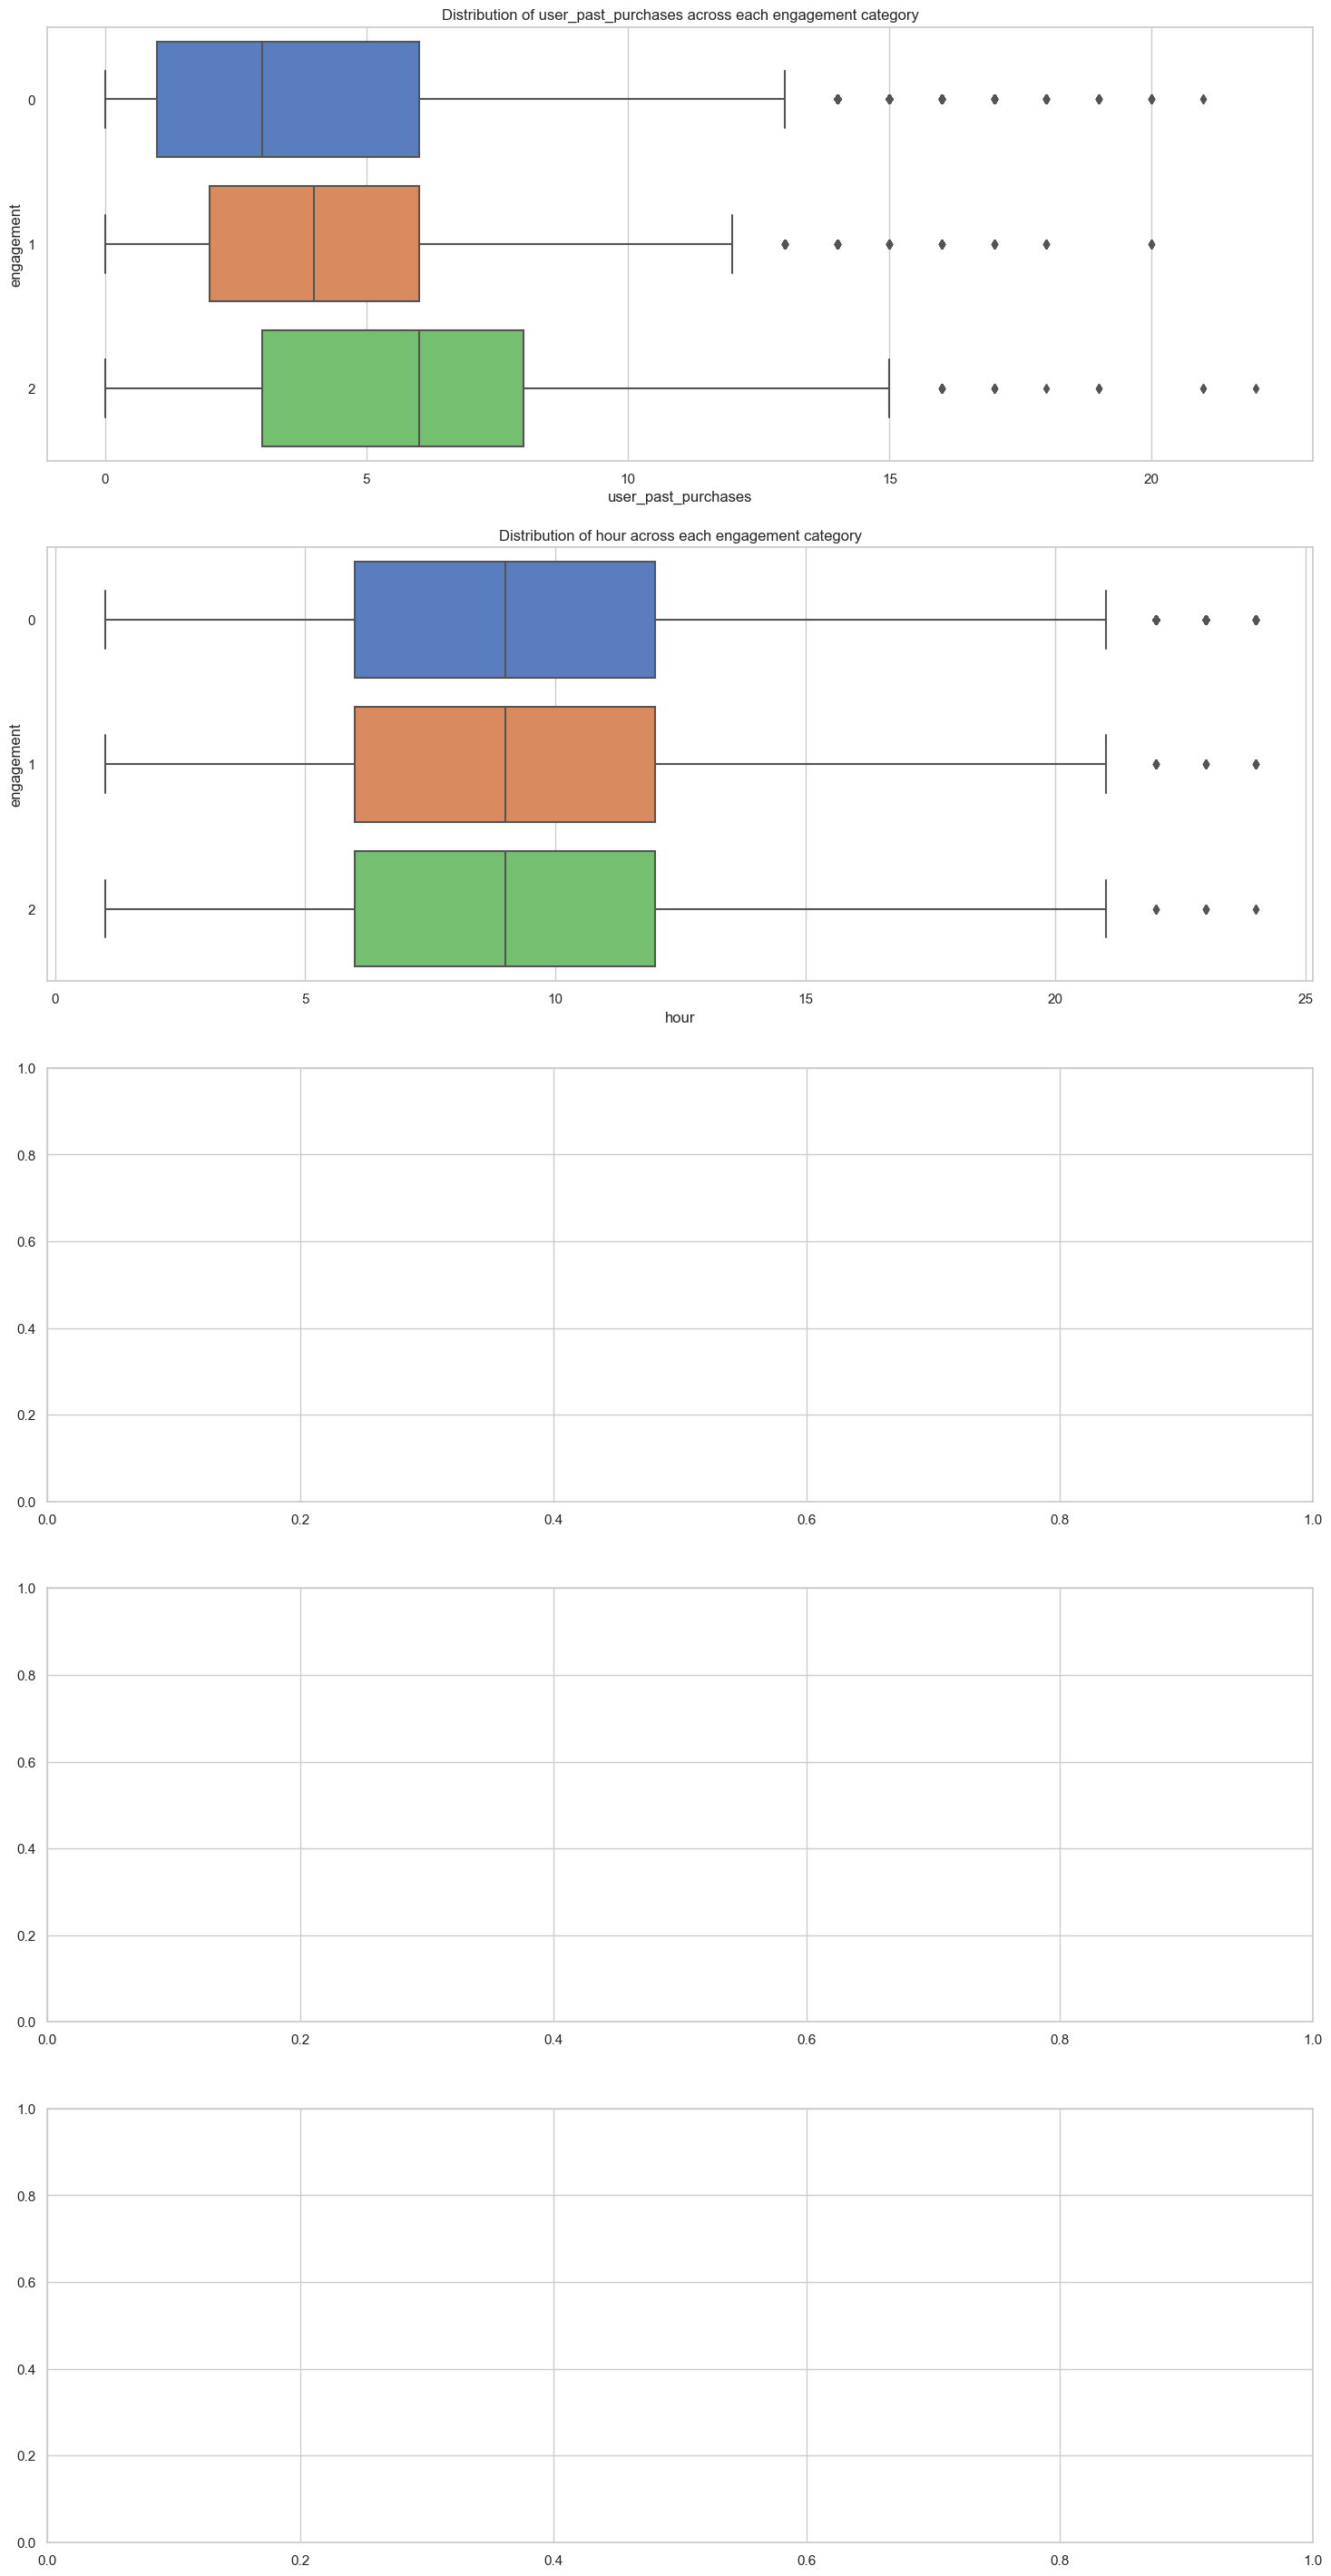

In [37]:
# generate box plots to show the distribution of numerical features in each category of engagement
numerical_features = ['user_past_purchases','hour']

fig, axes = plt.subplots(5, 1, figsize=(18, 36))

for row, feature in enumerate(numerical_features):
  sns.boxplot(ax=axes[row], data=campaign_df, x=feature, y='engagement', orient='h')
  axes[row].set_title(f"Distribution of {feature} across each engagement category")

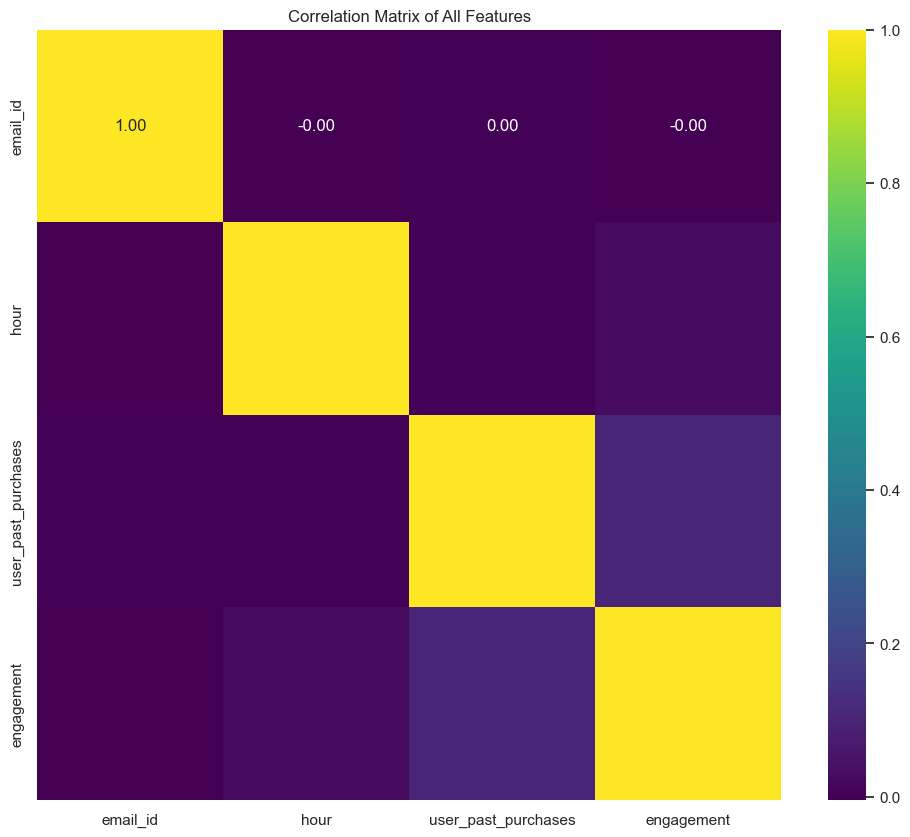

In [38]:
#  Calculate the correlation matrix
# Select only numerical features for correlation calculation
numerical_features = campaign_df.select_dtypes(include=np.number).columns
corr_matrix = campaign_df[numerical_features].corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))  # Adjust the figure size as needed
sns.heatmap(corr_matrix, annot=True, cmap='viridis', fmt=".2f")
plt.title("Correlation Matrix of All Features")
plt.show()

In [39]:
# exploring the head of the dataframe
campaign_df.head()

,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases,engagement
0,85120,short_email,personalized,2,Sunday,US,5,0
1,966622,long_email,personalized,12,Sunday,UK,2,2
2,777221,long_email,personalized,11,Wednesday,US,2,0
3,493711,short_email,generic,6,Monday,UK,1,0
4,106887,long_email,generic,14,Monday,US,6,0


In [40]:
campaign_df.drop('email_id', axis=1, inplace=True)

In [41]:
# exploring the head of the dataframe
campaign_df.head()

,email_text,email_version,hour,weekday,user_country,user_past_purchases,engagement
0,short_email,personalized,2,Sunday,US,5,0
1,long_email,personalized,12,Sunday,UK,2,2
2,long_email,personalized,11,Wednesday,US,2,0
3,short_email,generic,6,Monday,UK,1,0
4,long_email,generic,14,Monday,US,6,0


In [42]:
# calculate VIF of all numerical features
numerical_independant_features = ['user_past_purchases', 'hour']
calculate_vif_of_all_features(campaign_df[[column for column in campaign_df.describe().columns if column in numerical_independant_features]])

,Feature,VIF
0,hour,1.92823
1,user_past_purchases,1.92823


In [43]:
# exploring the head of the dataframe
campaign_df.head()

,email_text,email_version,hour,weekday,user_country,user_past_purchases,engagement
0,short_email,personalized,2,Sunday,US,5,0
1,long_email,personalized,12,Sunday,UK,2,2
2,long_email,personalized,11,Wednesday,US,2,0
3,short_email,generic,6,Monday,UK,1,0
4,long_email,generic,14,Monday,US,6,0


In [44]:
# calculate VIF of all numerical features
calculate_vif_of_all_features(campaign_df[[column for column in campaign_df.describe().columns if column in numerical_independant_features]])

,Feature,VIF
0,hour,1.92823
1,user_past_purchases,1.92823


Now, all features have VIF below 5.

Outliers in user_past_purchases : 778 (0.78%)


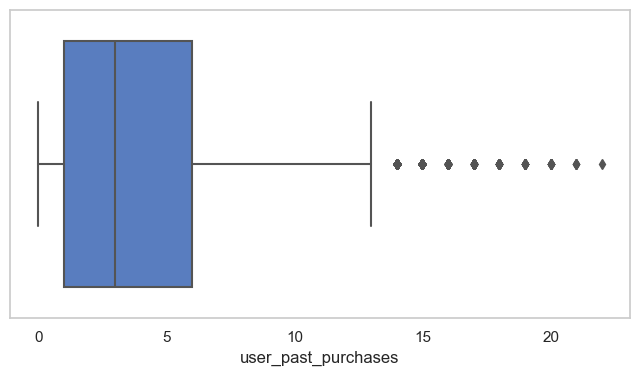

In [45]:
# generate a box plot for user_past_purchases
generate_horizontal_box_plot(campaign_df, 'user_past_purchases')

# count and percentage of outliers in user_past_purchases
count, perc = get_outlier_count_and_percentage(campaign_df, 'user_past_purchases')
print(f"Outliers in user_past_purchases : {count} ({perc}%)")

In [46]:
# remove outliers
upper_boundary, lower_boundary = get_outlier_boundaries(campaign_df, 'user_past_purchases')
campaign_df = campaign_df[(campaign_df['user_past_purchases'] > lower_boundary) & (campaign_df['user_past_purchases'] < (upper_boundary-0.2))]

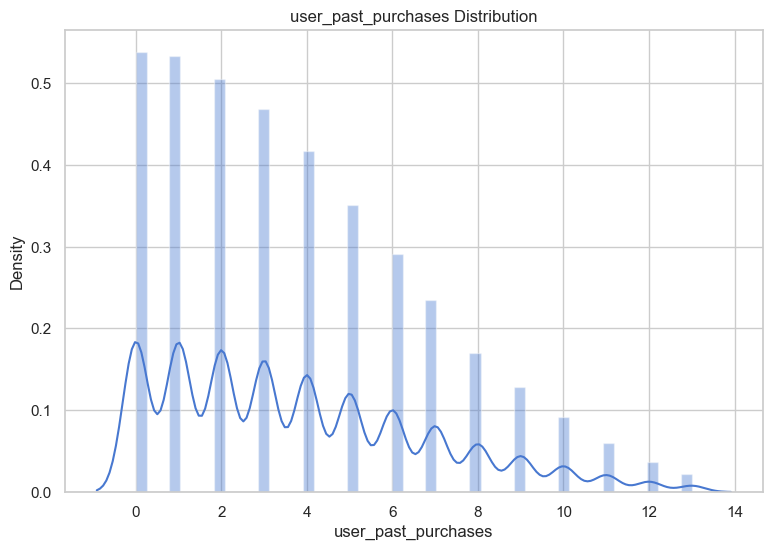

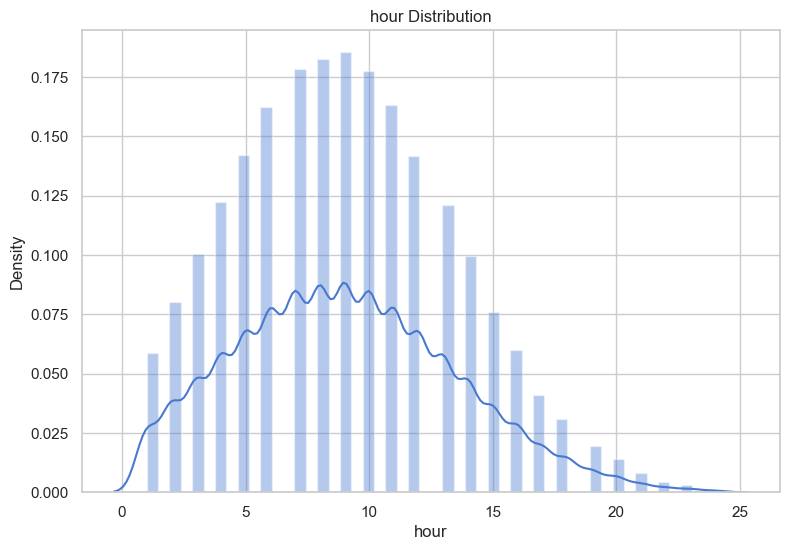

In [47]:
# numerical features
numerical_features = ['user_past_purchases', 'hour']

# generate density plot for numerical features
for feature in numerical_features:
  plt.figure(figsize=(9, 6))
  sns.distplot(campaign_df[feature]).set(title=f'{feature} Distribution')
  plt.show()

In [48]:
from sklearn.preprocessing import OneHotEncoder

categorical_features = ['email_text', 'email_version']

ohe = OneHotEncoder(dtype=int, handle_unknown='ignore', sparse_output=False) # remove 'sparse' argument and set sparse_output to False
# ohe.set_output(transform='dense') #to specify output format as 'dense' , remove this line causing the error
ohe.fit(campaign_df[categorical_features])
encoded_features = list(ohe.get_feature_names_out(categorical_features))
campaign_df[encoded_features] = ohe.transform(campaign_df[categorical_features])
campaign_df.drop(categorical_features, axis=1, inplace=True)

In [49]:
# exploring the head of the dataframe
campaign_df.head()

,hour,weekday,user_country,user_past_purchases,engagement,email_text_long_email,email_text_short_email,email_version_generic,email_version_personalized
0,2,Sunday,US,5,0,0,1,0,1
1,12,Sunday,UK,2,2,1,0,0,1
2,11,Wednesday,US,2,0,1,0,0,1
3,6,Monday,UK,1,0,0,1,1,0
4,14,Monday,US,6,0,1,0,1,0


In [50]:
from sklearn.preprocessing import OneHotEncoder

# Assuming your dataframe is named 'campaign_df'
categorical_features = ['weekday']

# Create a OneHotEncoder object
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore', dtype=int)  # sparse=False for dense output

# Fit the encoder to the 'weekday' column
ohe.fit(campaign_df[categorical_features])

# Get the feature names after encoding
encoded_features = list(ohe.get_feature_names_out(categorical_features))

# Transform the 'weekday' column and add the encoded features to the dataframe
campaign_df[encoded_features] = ohe.transform(campaign_df[categorical_features])

# Drop the original 'weekday' column
campaign_df.drop(categorical_features, axis=1, inplace=True)

In [51]:
from sklearn.preprocessing import OneHotEncoder

# Assuming your dataframe is named 'campaign_df'
categorical_features = ['user_country']

# Create a OneHotEncoder object
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore', dtype=int)  # sparse=False for dense output

# Fit the encoder to the 'weekday' column
ohe.fit(campaign_df[categorical_features])

# Get the feature names after encoding
encoded_features = list(ohe.get_feature_names_out(categorical_features))

# Transform the 'weekday' column and add the encoded features to the dataframe
campaign_df[encoded_features] = ohe.transform(campaign_df[categorical_features])

# Drop the original 'weekday' column
campaign_df.drop(categorical_features, axis=1, inplace=True)

In [52]:
# exploring the head of the dataframe
campaign_df.head()

,hour,user_past_purchases,engagement,email_text_long_email,email_text_short_email,email_version_generic,email_version_personalized,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,user_country_ES,user_country_FR,user_country_UK,user_country_US
0,2,5,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1
1,12,2,2,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0
2,11,2,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1
3,6,1,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0
4,14,6,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1


In [53]:
# Assuming your dataframe is named 'campaign_df'
# Select only numerical features for correlation calculation
numerical_features = campaign_df.select_dtypes(include=np.number).columns
corr_matrix = campaign_df[numerical_features].corr()

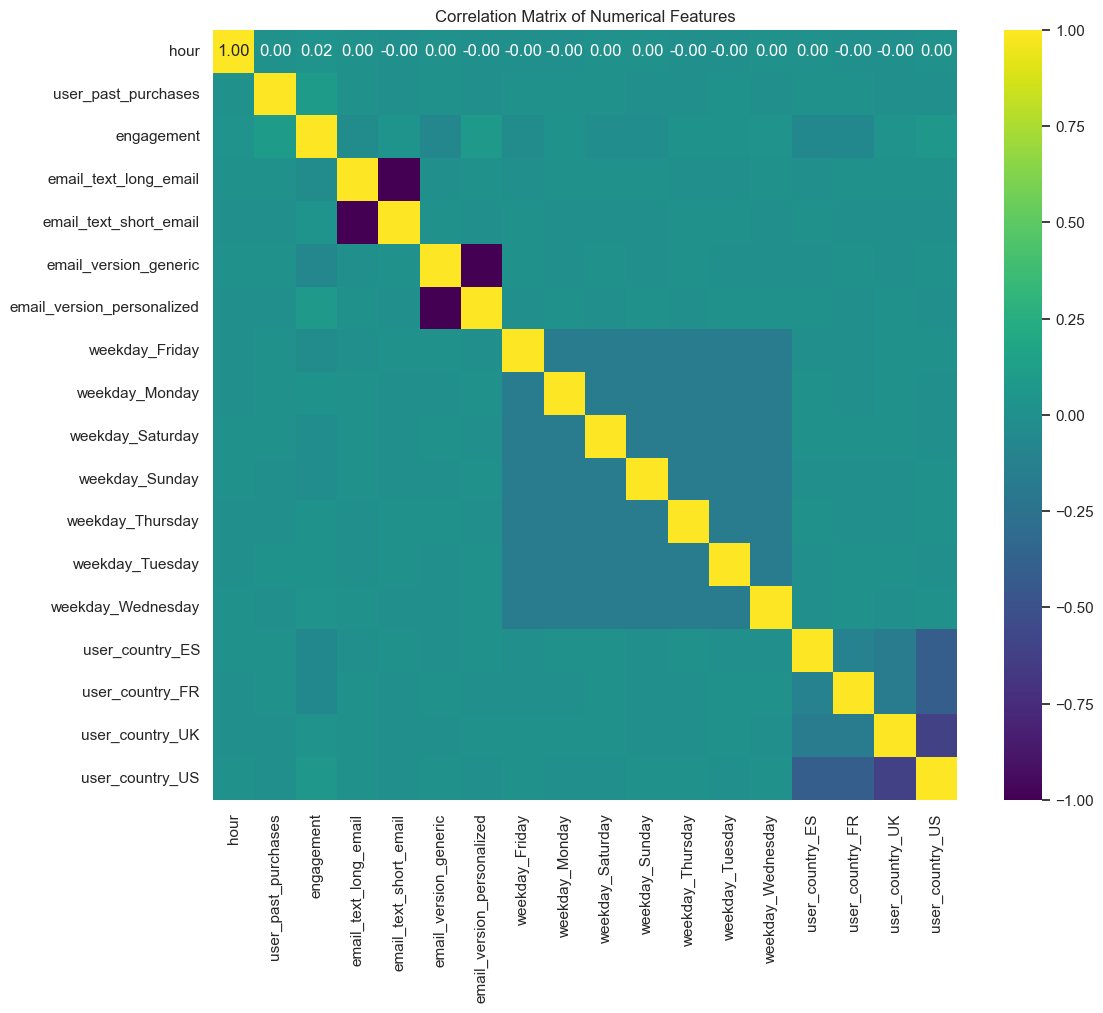

In [54]:
# Plot the heatmap
plt.figure(figsize=(12, 10))  # Adjust the figure size as needed
sns.heatmap(corr_matrix, annot=True, cmap='viridis', fmt=".2f")
plt.title("Correlation Matrix of Numerical Features")
plt.show()

## Train-Test Split

First, we will separate independant features and dependant feature.

In [55]:
# independant features
X = campaign_df.drop('engagement', axis=1)

# dependant feature
y = campaign_df['engagement']

Now, lets split them into training and test data with 25% test data.

In [56]:
# split the datasets to training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 0)
print(X_train.shape)
print(X_test.shape)

(74416, 17)
(24806, 17)


## Feature Scaling

Scaling of features is important because algorithms like logistic regression, which is based on gradient descent, performs better when features are relatively on a similar scale.

So training and test data of independant features are scaled using standardization.

In [57]:
# standardization of independant training and testing data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Handling Data Imbalance

We have already established in EDA that the dataset is highly imbalanced. If we train the models without fixing this problem, the model will be completely biased. So, we will use 2 different techniques to balance training data: Random Undersampling and SMOTE.

In [58]:
# use undersampling to eliminate data imbalance
rus = RandomUnderSampler(replacement=True)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

In [59]:
# use oversampling to eliminate data imbalance
smote = SMOTE()
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

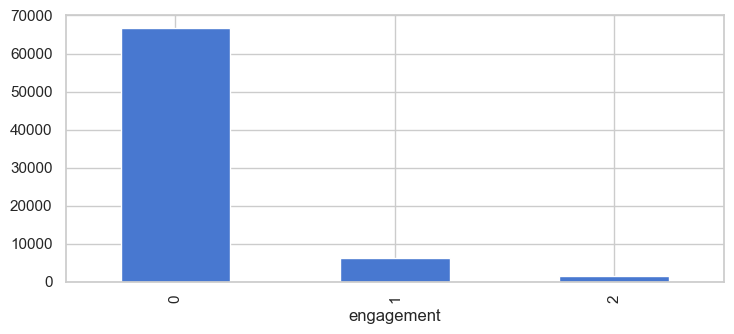

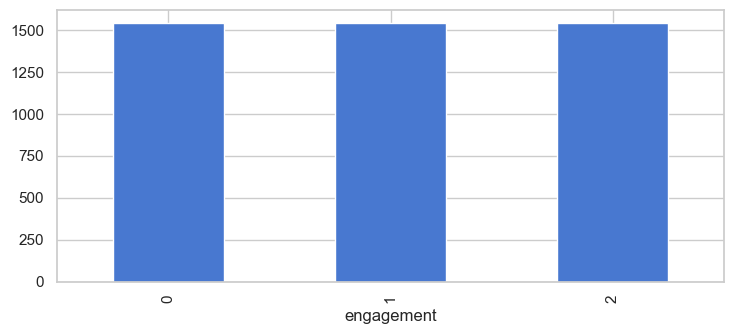

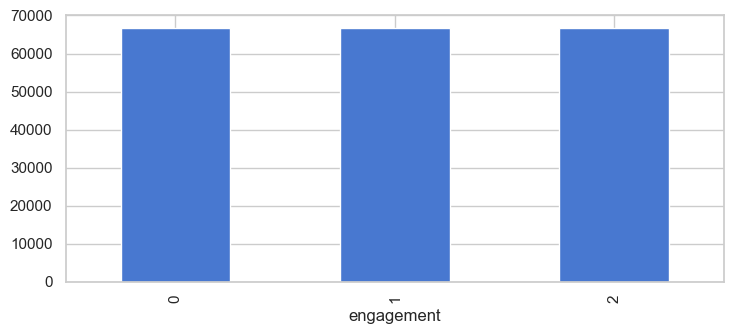

In [60]:
# generating a count plot to check data imbalance
generate_count_plot(y_train)
generate_count_plot(y_train_rus)
generate_count_plot(y_train_smote)

Now we have a balance dataset. Each class in undersampled data has number of samples equal to the smallest original class whereas each class in oversampled data has number of samples equal to the largest original class.

Lets create a dataframe to store all calculated model metrics.

In [61]:
# create a dataframe to store metrics related to models
metrics_table = pd.DataFrame(columns=['Model', 'Sampling', 'Train_Accuracy', 'Test_Accuracy', 'Train_Precision', 'Test_Precision',
                                      'Train_Recall', 'Test_Recall', 'Train_F1Score', 'Test_F1Score', 'Train_ROC_AUC', 'Test_ROC_AUC'])

## Model Training

### Logistic Regression with Hyperparameter Tuning

In [62]:
# initialize hyperparameters for logistic regression
log_reg = LogisticRegression(multi_class='multinomial', class_weight='balanced')
parameters = {'solver':['lbfgs', 'newton-cg', 'saga'],
              'C':[0.01, 0.1, 1],
              'max_iter':[50, 80, 100]}

The best parameters: 
solver=newton-cg
max_iter=80
C=0.1

Best score: 0.47042667654548803

Training Data
Accuracy  : 47.517271 %
Precision : 47.450035 %
Recall    : 47.517271 %
F1 Score  : 47.475437 %
ROC AUC   : 0.661481

Testing Data
Accuracy  : 49.524309 %
Precision : 85.6471 %
Recall    : 49.524309 %
F1 Score  : 60.584762 %
ROC AUC   : 0.660855



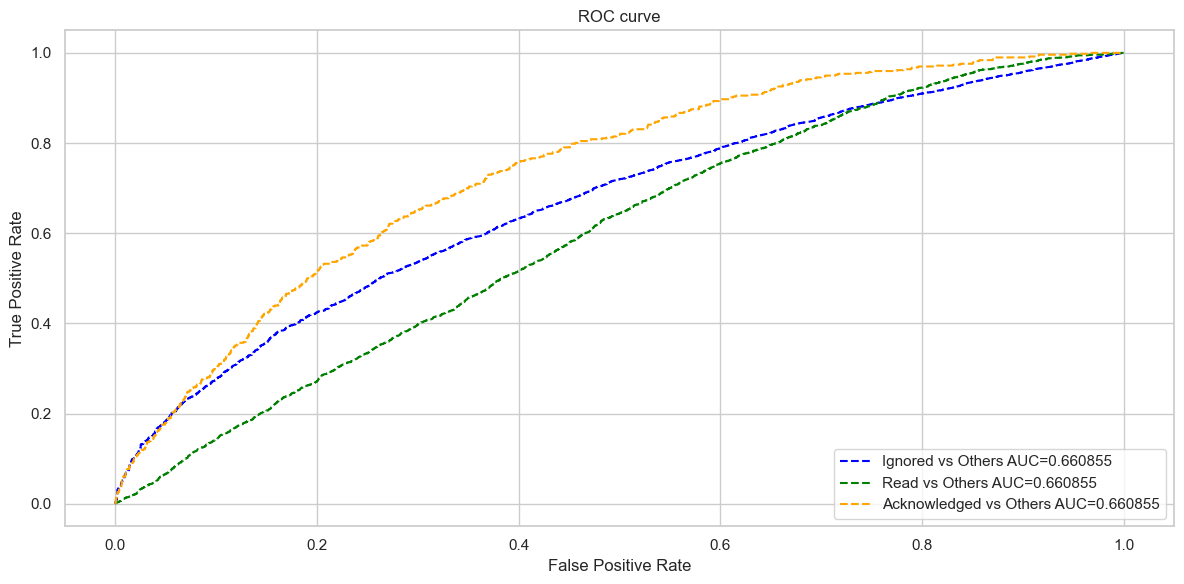

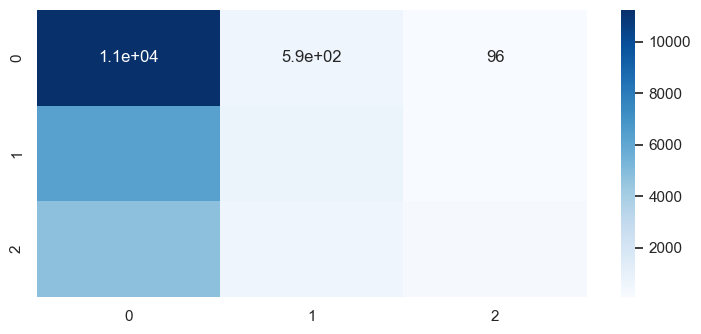

In [63]:
# train data with logistic regression on random undersampling
log_reg_rus = RandomizedSearchCV(log_reg, parameters, cv=5, n_iter=10)
log_reg_rus.fit(X_train_rus, y_train_rus)

# model evaluation
model_evaluation = calculate_model_metrics(log_reg_rus, X_train_rus, y_train_rus, X_test, y_test)

# add metrics to metrics table
metrics_table.loc[len(metrics_table.index)] = ['Logistic Regression', 'RandomUnderSampling',
                                                model_evaluation['Train_Accuracy'], model_evaluation['Train_Precision'],
                                                model_evaluation['Train_Recall'], model_evaluation['Train_F1_Score'],
                                                model_evaluation['Train_ROC_AUC'], model_evaluation['Test_Accuracy'],
                                                model_evaluation['Test_Precision'], model_evaluation['Test_Recall'],
                                                model_evaluation['Test_F1_Score'], model_evaluation['Test_ROC_AUC']]

The best parameters: 
solver=newton-cg
max_iter=50
C=1

Best score: 0.47076111514659413

Training Data
Accuracy  : 47.082609 %
Precision : 46.800616 %
Recall    : 47.082609 %
F1 Score  : 46.879785 %
ROC AUC   : 0.658923

Testing Data
Accuracy  : 50.524067 %
Precision : 85.607264 %
Recall    : 50.524067 %
F1 Score  : 61.548513 %
ROC AUC   : 0.660772



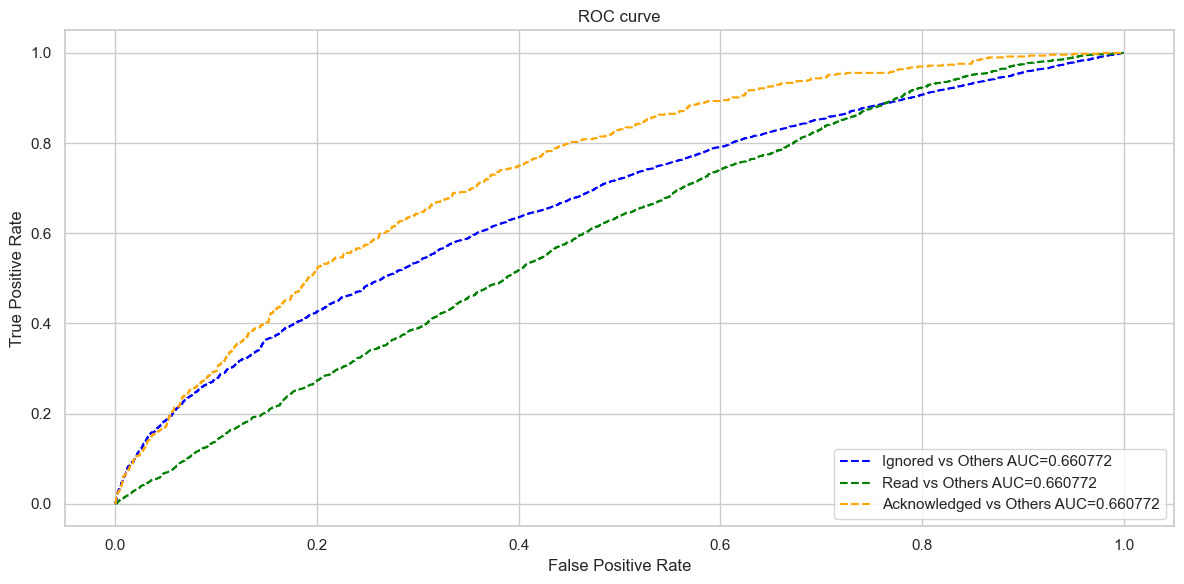

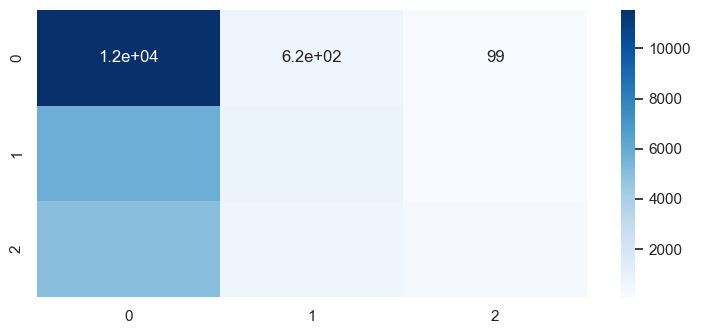

In [64]:
# train data with logistic regression on SMOTE
log_reg_smote = RandomizedSearchCV(log_reg, parameters, cv=5, n_iter=10)
log_reg_smote.fit(X_train_smote, y_train_smote)

# model evaluation
model_evaluation = calculate_model_metrics(log_reg_smote, X_train_smote, y_train_smote, X_test, y_test)

# add metrics to metrics table
metrics_table.loc[len(metrics_table.index)] = ['Logistic Regression', 'SMOTE',
                                                model_evaluation['Train_Accuracy'], model_evaluation['Train_Precision'],
                                                model_evaluation['Train_Recall'], model_evaluation['Train_F1_Score'],
                                                model_evaluation['Train_ROC_AUC'], model_evaluation['Test_Accuracy'],
                                                model_evaluation['Test_Precision'], model_evaluation['Test_Recall'],
                                                model_evaluation['Test_F1_Score'], model_evaluation['Test_ROC_AUC']]

### Decision Tree with Hyperparameter Tuning

In [65]:
# initialize hyperparameters for decision tree classifier
decision_tree = DecisionTreeClassifier()
parameters = {'max_depth': [5, 10, None],
              'min_samples_leaf': [1, 2, 5],
              'min_samples_split': [2, 5, 10],
              'max_leaf_nodes': [5, 20, 100],
              'max_features': ['auto', 'sqrt', 'log2']}

The best parameters: 
min_samples_split=5
min_samples_leaf=1
max_leaf_nodes=20
max_features=sqrt
max_depth=5

Best score: 0.43954347729851523

Training Data
Accuracy  : 44.66753 %
Precision : 44.000293 %
Recall    : 44.66753 %
F1 Score  : 43.528465 %
ROC AUC   : 0.626055

Testing Data
Accuracy  : 51.06829 %
Precision : 84.752264 %
Recall    : 51.06829 %
F1 Score  : 62.546241 %
ROC AUC   : 0.62929



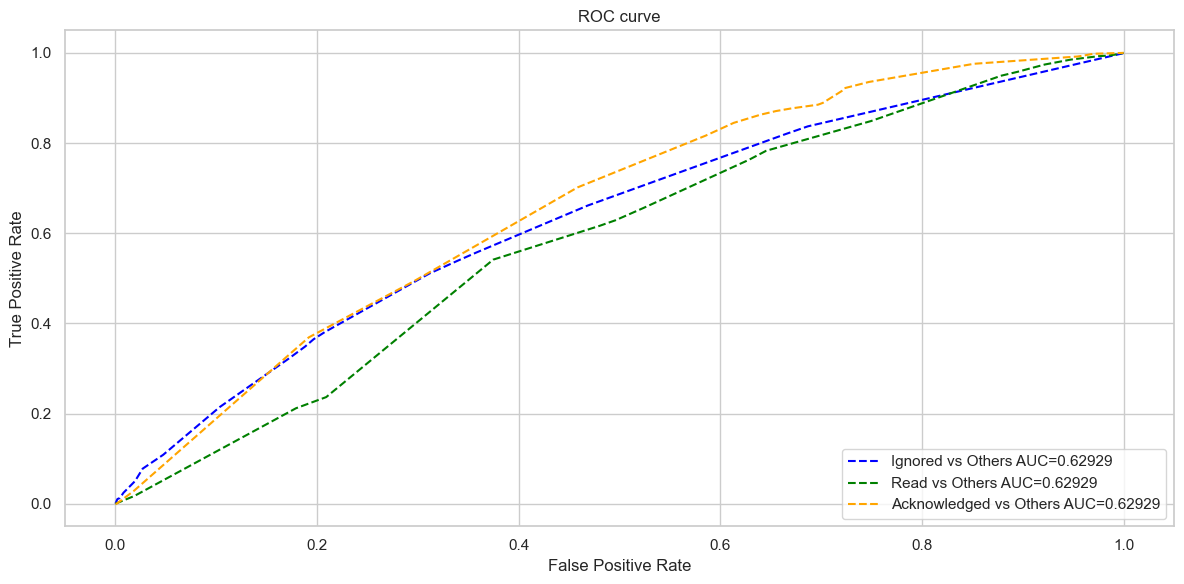

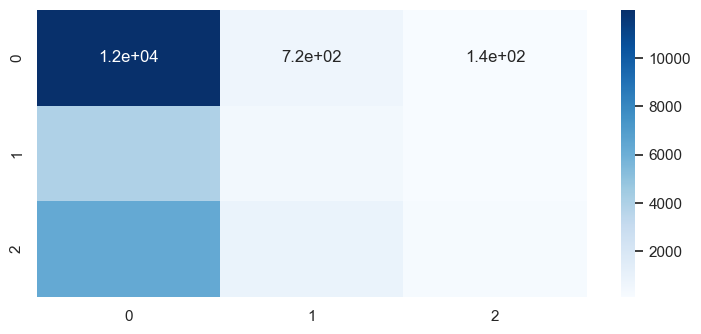

In [66]:
# train data with decision tree on random undersampling
dt_rus = RandomizedSearchCV(decision_tree, parameters, cv=5, n_iter=10)
dt_rus.fit(X_train_rus, y_train_rus)

# model evaluation
model_evaluation = calculate_model_metrics(dt_rus, X_train_rus, y_train_rus, X_test, y_test)

# add metrics to metrics table
metrics_table.loc[len(metrics_table.index)] = ['Decision Tree', 'RandomUnderSampling',
                                                model_evaluation['Train_Accuracy'], model_evaluation['Train_Precision'],
                                                model_evaluation['Train_Recall'], model_evaluation['Train_F1_Score'],
                                                model_evaluation['Train_ROC_AUC'], model_evaluation['Test_Accuracy'],
                                                model_evaluation['Test_Precision'], model_evaluation['Test_Recall'],
                                                model_evaluation['Test_F1_Score'], model_evaluation['Test_ROC_AUC']]

The best parameters: 
min_samples_split=2
min_samples_leaf=1
max_leaf_nodes=100
max_features=auto
max_depth=None

Best score: 0.5066225484066026

Training Data
Accuracy  : 49.643635 %
Precision : 51.824973 %
Recall    : 49.643635 %
F1 Score  : 46.423609 %
ROC AUC   : 0.680194

Testing Data
Accuracy  : 42.251875 %
Precision : 85.796805 %
Recall    : 42.251875 %
F1 Score  : 54.971121 %
ROC AUC   : 0.6398



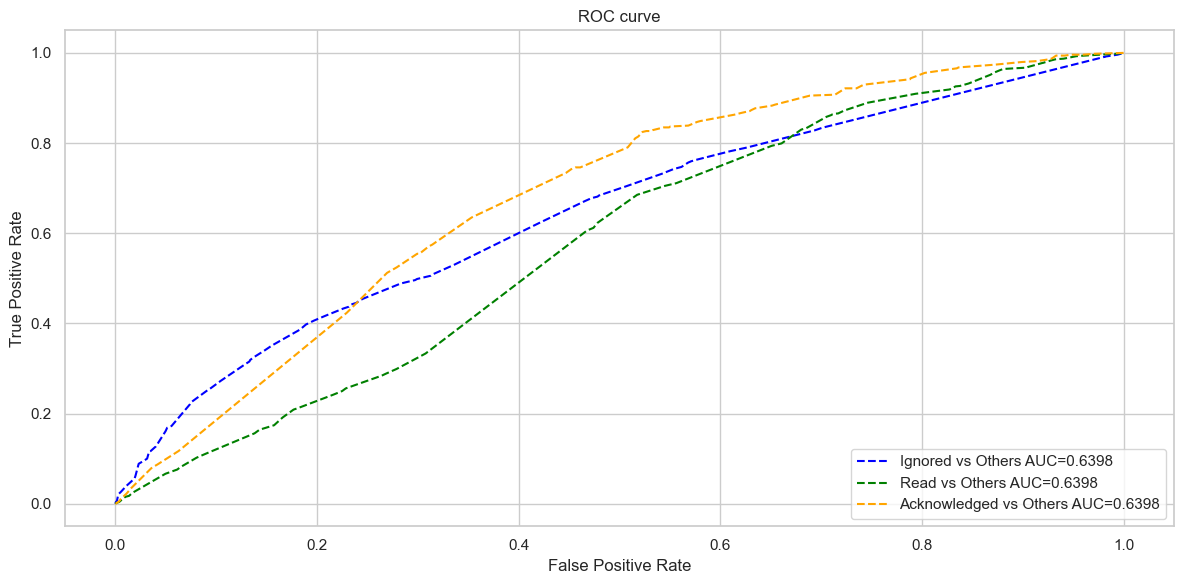

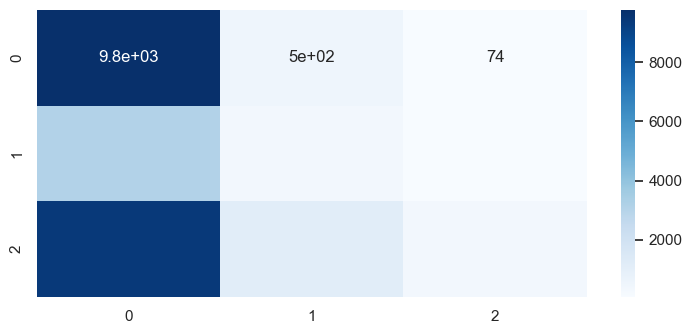

In [67]:
# train data with decision tree on SMOTE
dt_smote = RandomizedSearchCV(decision_tree, parameters, cv=5, n_iter=10)
dt_smote.fit(X_train_smote, y_train_smote)

# model evaluation
model_evaluation = calculate_model_metrics(dt_smote, X_train_smote, y_train_smote, X_test, y_test)

# add metrics to metrics table
metrics_table.loc[len(metrics_table.index)] = ['Decision Tree', 'SMOTE',
                                                model_evaluation['Train_Accuracy'], model_evaluation['Train_Precision'],
                                                model_evaluation['Train_Recall'], model_evaluation['Train_F1_Score'],
                                                model_evaluation['Train_ROC_AUC'], model_evaluation['Test_Accuracy'],
                                                model_evaluation['Test_Precision'], model_evaluation['Test_Recall'],
                                                model_evaluation['Test_F1_Score'], model_evaluation['Test_ROC_AUC']]

### Random Forest with Hyperparameter Tuning

In [68]:
# initialize hyperparameters for random forest classifier
random_forest = RandomForestClassifier()
parameters = {'max_depth': [5, 10, None],
              'min_samples_leaf': [1, 2, 5],
              'min_samples_split': [2, 5, 10],
              'max_leaf_nodes': [5, 20, 100],
              'max_features': ['auto', 'sqrt', 'log2']}

The best parameters: 
min_samples_split=10
min_samples_leaf=5
max_leaf_nodes=100
max_features=auto
max_depth=5

Best score: 0.468265218394179

Training Data
Accuracy  : 49.222798 %
Precision : 49.223299 %
Recall    : 49.222798 %
F1 Score  : 49.175204 %
ROC AUC   : 0.685836

Testing Data
Accuracy  : 50.177376 %
Precision : 85.90336 %
Recall    : 50.177376 %
F1 Score  : 61.283988 %
ROC AUC   : 0.665122



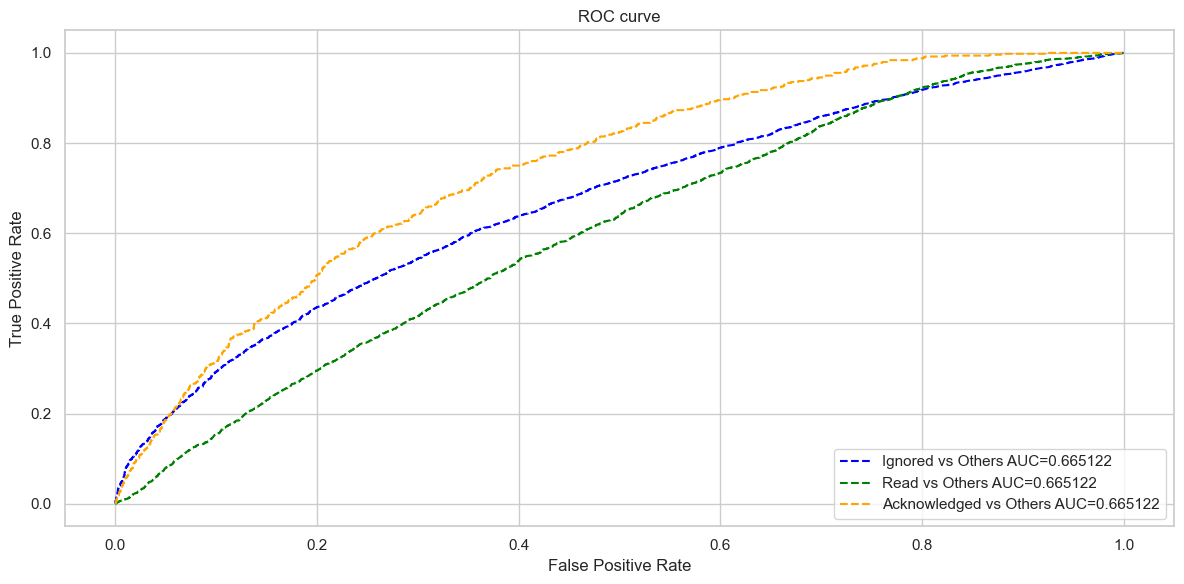

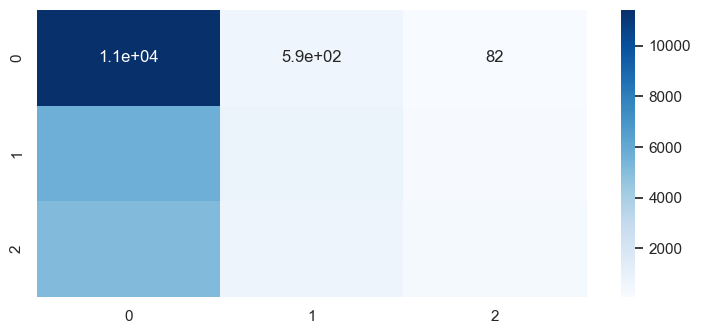

In [69]:
# train data with random forest on random undersampling
rf_rus = RandomizedSearchCV(random_forest, parameters, cv=5, n_iter=10)
rf_rus.fit(X_train_rus, y_train_rus)

# model evaluation
model_evaluation = calculate_model_metrics(rf_rus, X_train_rus, y_train_rus, X_test, y_test)

# add metrics to metrics table
metrics_table.loc[len(metrics_table.index)] = ['Random Forest', 'RandomUnderSampling',
                                                model_evaluation['Train_Accuracy'], model_evaluation['Train_Precision'],
                                                model_evaluation['Train_Recall'], model_evaluation['Train_F1_Score'],
                                                model_evaluation['Train_ROC_AUC'], model_evaluation['Test_Accuracy'],
                                                model_evaluation['Test_Precision'], model_evaluation['Test_Recall'],
                                                model_evaluation['Test_F1_Score'], model_evaluation['Test_ROC_AUC']]

The best parameters: 
min_samples_split=2
min_samples_leaf=2
max_leaf_nodes=100
max_features=log2
max_depth=None

Best score: 0.6001020461489277

Training Data
Accuracy  : 60.258102 %
Precision : 60.3228 %
Recall    : 60.258102 %
F1 Score  : 59.0406 %
ROC AUC   : 0.783722

Testing Data
Accuracy  : 57.594937 %
Precision : 85.320721 %
Recall    : 57.594937 %
F1 Score  : 67.456335 %
ROC AUC   : 0.662324



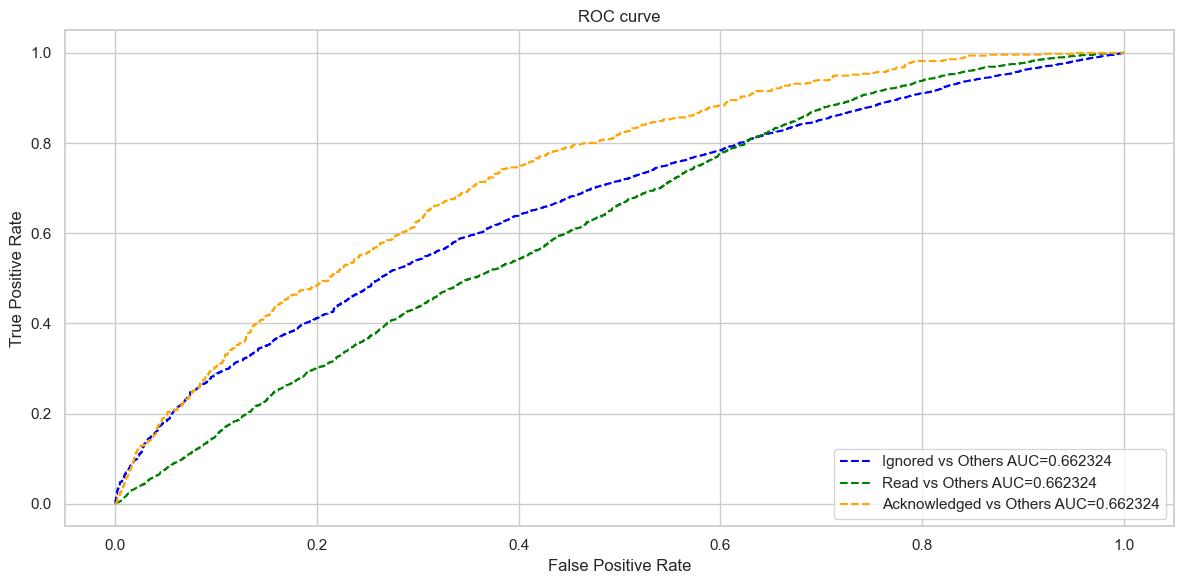

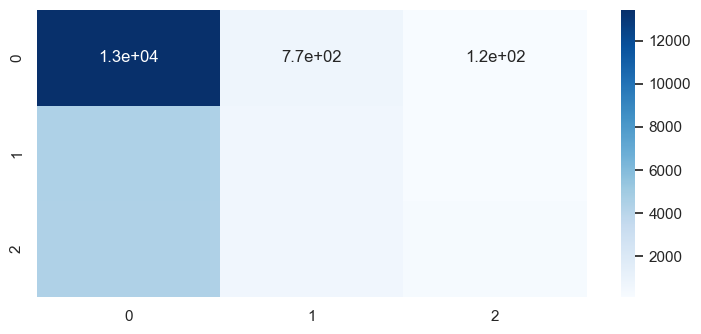

In [70]:
# train data with random forest on SMOTE
rf_smote = RandomizedSearchCV(random_forest, parameters, cv=5, n_iter=10)
rf_smote.fit(X_train_smote, y_train_smote)

# model evaluation
model_evaluation = calculate_model_metrics(rf_smote, X_train_smote, y_train_smote, X_test, y_test)

# add metrics to metrics table
metrics_table.loc[len(metrics_table.index)] = ['Random Forest', 'SMOTE',
                                                model_evaluation['Train_Accuracy'], model_evaluation['Train_Precision'],
                                                model_evaluation['Train_Recall'], model_evaluation['Train_F1_Score'],
                                                model_evaluation['Train_ROC_AUC'], model_evaluation['Test_Accuracy'],
                                                model_evaluation['Test_Precision'], model_evaluation['Test_Recall'],
                                                model_evaluation['Test_F1_Score'], model_evaluation['Test_ROC_AUC']]

### XGBoost with Hyperparameter Tuning

In [71]:
# initialize hyperparameters for XGBoost classifier
xgboost = xgb.XGBClassifier(objective='multi:softmax', verbosity=0)
parameters = {'max_depth': [2, 5, 10],
              'learning_rate': [0.05, 0.1, 0.2],
              'min_child_weight': [1, 2, 5],
              'gamma': [0, 0.1, 0.3],
              'colsample_bytree': [0.3, 0.5, 0.7]}

The best parameters: 
min_child_weight=1
max_depth=5
learning_rate=0.1
gamma=0.3
colsample_bytree=0.5

Best score: 0.4676184351853793

Training Data
Accuracy  : 53.259931 %
Precision : 53.572669 %
Recall    : 53.259931 %
F1 Score  : 53.226616 %
ROC AUC   : 0.730208

Testing Data
Accuracy  : 47.415948 %
Precision : 85.936134 %
Recall    : 47.415948 %
F1 Score  : 58.876669 %
ROC AUC   : 0.664369



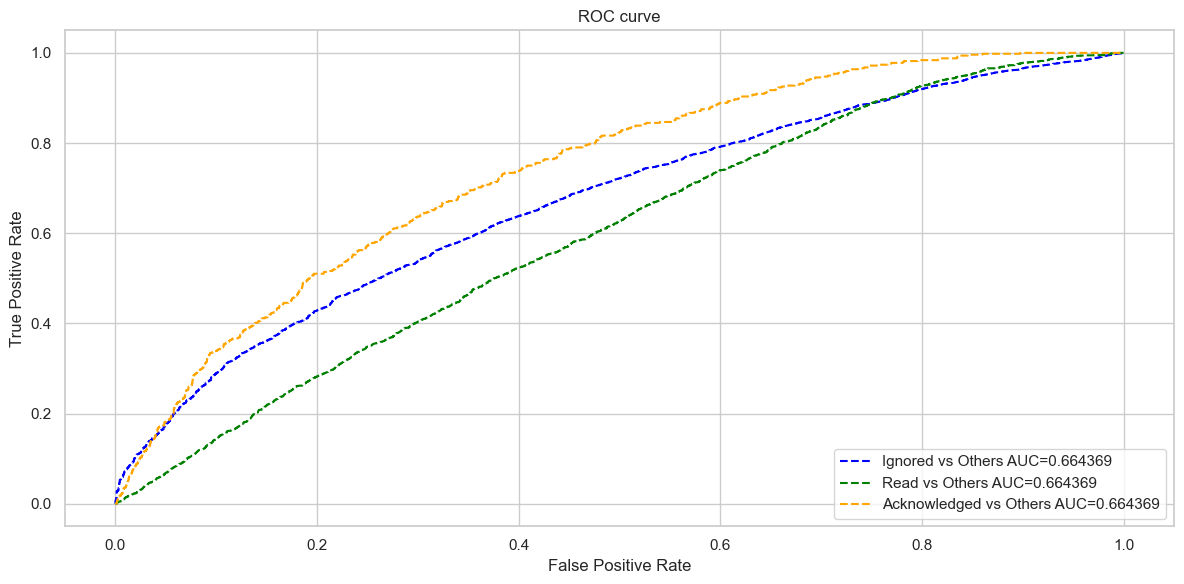

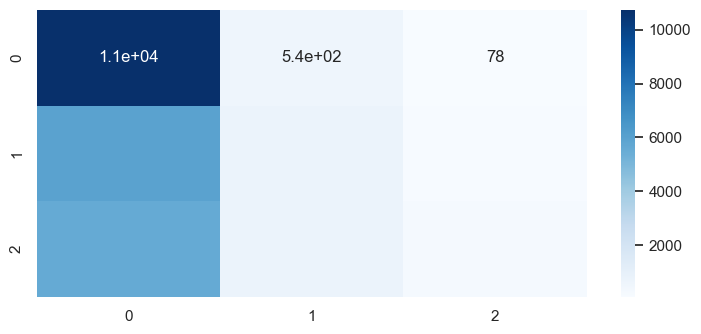

In [72]:
# train data with XGBoost on random undersampling
xgb_rus = RandomizedSearchCV(xgboost, parameters, cv=5, n_iter=10)
xgb_rus.fit(X_train_rus, y_train_rus)

# model evaluation
model_evaluation = calculate_model_metrics(xgb_rus, X_train_rus, y_train_rus, X_test, y_test)

# add metrics to metrics table
metrics_table.loc[len(metrics_table.index)] = ['XGBoost', 'RandomUnderSampling',
                                                model_evaluation['Train_Accuracy'], model_evaluation['Train_Precision'],
                                                model_evaluation['Train_Recall'], model_evaluation['Train_F1_Score'],
                                                model_evaluation['Train_ROC_AUC'], model_evaluation['Test_Accuracy'],
                                                model_evaluation['Test_Precision'], model_evaluation['Test_Recall'],
                                                model_evaluation['Test_F1_Score'], model_evaluation['Test_ROC_AUC']]

The best parameters: 
min_child_weight=5
max_depth=10
learning_rate=0.2
gamma=0.3
colsample_bytree=0.5

Best score: 0.7799340721040086

Training Data
Accuracy  : 79.983606 %
Precision : 80.30753 %
Recall    : 79.983606 %
F1 Score  : 79.243888 %
ROC AUC   : 0.93114

Testing Data
Accuracy  : 86.479078 %
Precision : 82.314962 %
Recall    : 86.479078 %
F1 Score  : 84.211642 %
ROC AUC   : 0.64854



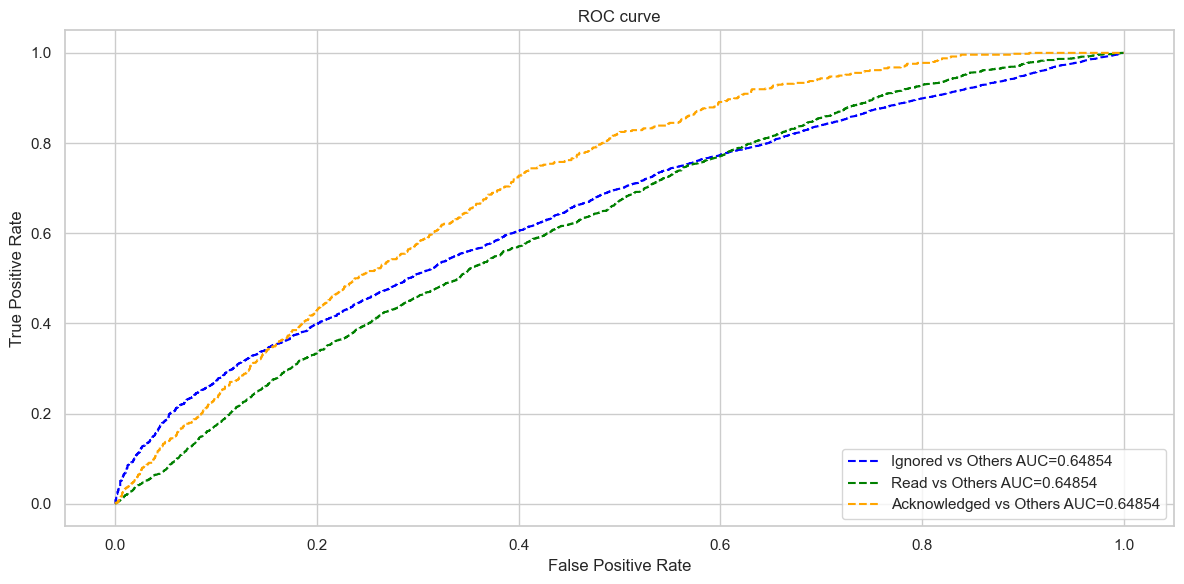

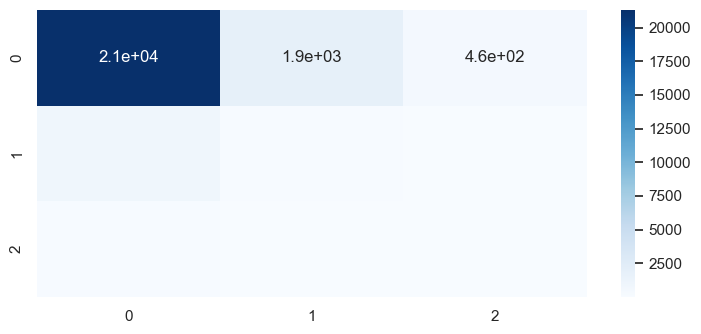

In [73]:
# train data with XGBoost on SMOTE
xgb_smote = RandomizedSearchCV(xgboost, parameters, cv=5, n_iter=10)
xgb_smote.fit(X_train_smote, y_train_smote)

# model evaluation
model_evaluation = calculate_model_metrics(xgb_smote, X_train_smote, y_train_smote, X_test, y_test)

# add metrics to metrics table
metrics_table.loc[len(metrics_table.index)] = ['XGBoost', 'SMOTE',
                                                model_evaluation['Train_Accuracy'], model_evaluation['Train_Precision'],
                                                model_evaluation['Train_Recall'], model_evaluation['Train_F1_Score'],
                                                model_evaluation['Train_ROC_AUC'], model_evaluation['Test_Accuracy'],
                                                model_evaluation['Test_Precision'], model_evaluation['Test_Recall'],
                                                model_evaluation['Test_F1_Score'], model_evaluation['Test_ROC_AUC']]

**LIGHTGBM And Hyperparameter Tuning**

In [74]:
!pip install lightgbm

Defaulting to user installation because normal site-packages is not writeable


In [75]:
#  Initialize hyperparameters for LightGBM classifier
from lightgbm import LGBMClassifier
lightgbm = LGBMClassifier(objective='multiclass', verbosity=-1)
lightgbm_parameters = {
    'max_depth': [2, 5, 10],
    'learning_rate': [0.05, 0.1, 0.2],
    'num_leaves': [31, 100, 200],  # Similar to max_leaf_nodes in other models
    # Other LightGBM-specific parameters can be added here
}

The best parameters: 
num_leaves=31
max_depth=2
learning_rate=0.05

Best score: 0.4702132567258698

Training Data
Accuracy  : 48.639896 %
Precision : 49.210745 %
Recall    : 48.639896 %
F1 Score  : 48.661765 %
ROC AUC   : 0.675106

Testing Data
Accuracy  : 45.714746 %
Precision : 86.306326 %
Recall    : 45.714746 %
F1 Score  : 57.21372 %
ROC AUC   : 0.665207



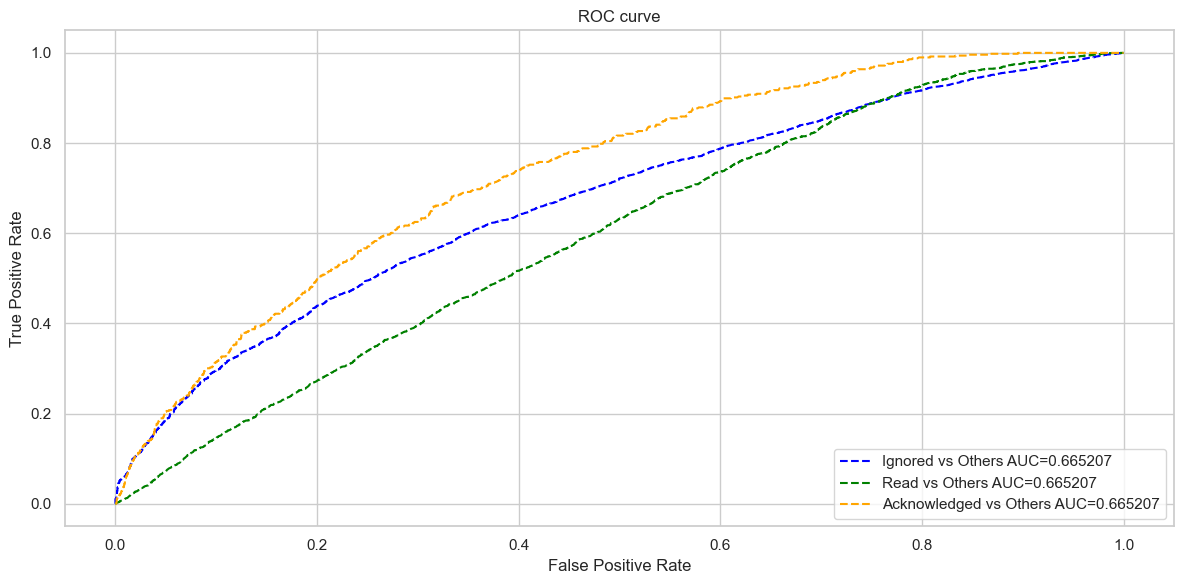

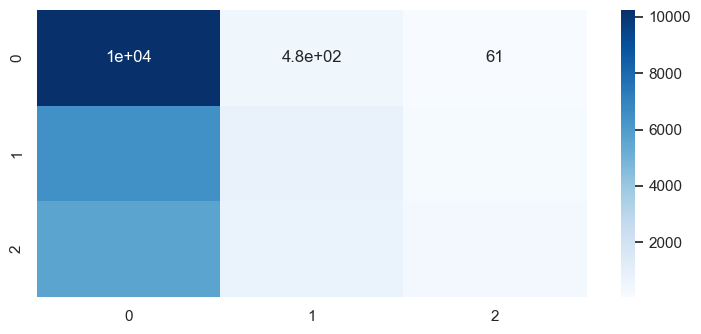

In [76]:
# Train data with LightGBM on random undersampling
lightgbm_rus = RandomizedSearchCV(lightgbm, lightgbm_parameters, cv=5, n_iter=10)
lightgbm_rus.fit(X_train_rus, y_train_rus)

# Model evaluation
model_evaluation = calculate_model_metrics(lightgbm_rus, X_train_rus, y_train_rus, X_test, y_test)

# Add metrics to metrics table
metrics_table.loc[len(metrics_table.index)] = ['LightGBM', 'RandomUnderSampling',
                                                model_evaluation['Train_Accuracy'], model_evaluation['Train_Precision'],
                                                model_evaluation['Train_Recall'], model_evaluation['Train_F1_Score'],
                                                model_evaluation['Train_ROC_AUC'], model_evaluation['Test_Accuracy'],
                                                model_evaluation['Test_Precision'], model_evaluation['Test_Recall'],
                                                model_evaluation['Test_F1_Score'], model_evaluation['Test_ROC_AUC']]

The best parameters: 
num_leaves=200
max_depth=10
learning_rate=0.1

Best score: 0.8130815081189816

Training Data
Accuracy  : 83.063436 %
Precision : 83.220657 %
Recall    : 83.063436 %
F1 Score  : 82.528722 %
ROC AUC   : 0.94774

Testing Data
Accuracy  : 86.575828 %
Precision : 82.382025 %
Recall    : 86.575828 %
F1 Score  : 84.301783 %
ROC AUC   : 0.640372



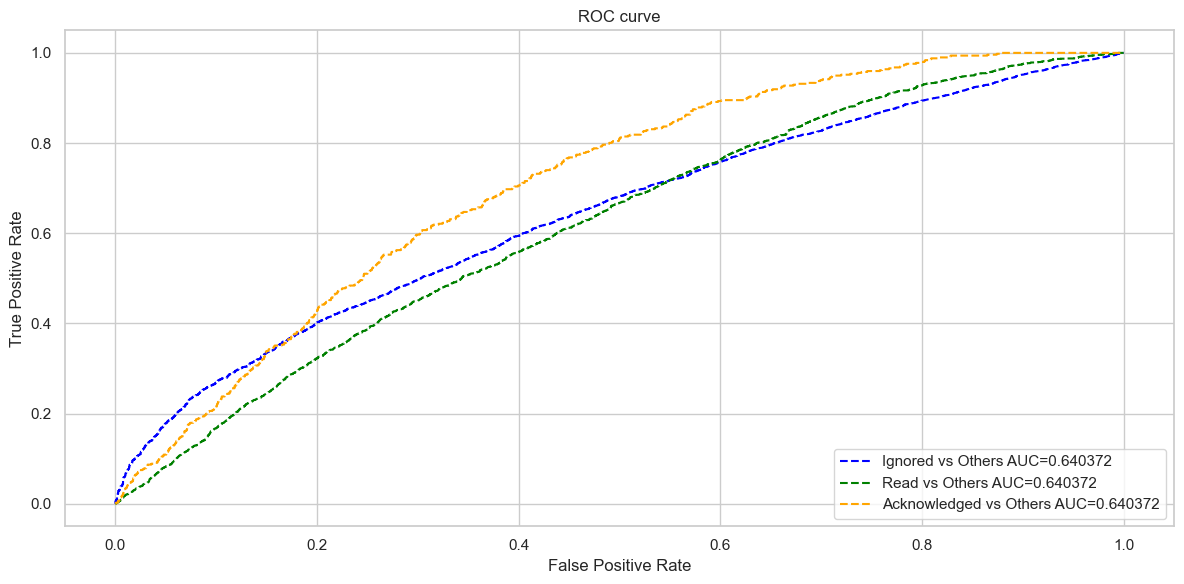

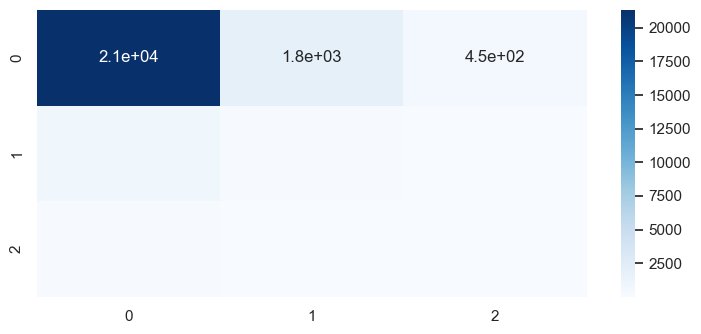

In [77]:
# Train data with LightGBM on SMOTE
lightgbm_smote = RandomizedSearchCV(lightgbm, lightgbm_parameters, cv=5, n_iter=10)
lightgbm_smote.fit(X_train_smote, y_train_smote)  # Using SMOTE data

# Model evaluation
model_evaluation = calculate_model_metrics(lightgbm_smote, X_train_smote, y_train_smote, X_test, y_test)

# Add metrics to metrics table
metrics_table.loc[len(metrics_table.index)] = ['LightGBM', 'SMOTE',
                                                model_evaluation['Train_Accuracy'], model_evaluation['Train_Precision'],
                                                model_evaluation['Train_Recall'], model_evaluation['Train_F1_Score'],
                                                model_evaluation['Train_ROC_AUC'], model_evaluation['Test_Accuracy'],
                                                model_evaluation['Test_Precision'], model_evaluation['Test_Recall'],
                                                model_evaluation['Test_F1_Score'], model_evaluation['Test_ROC_AUC']]

### KNN with Hyperparameter Tuning

In [78]:
# initialize hyperparameters for knn classifier
knn = KNeighborsClassifier()
parameters = {'n_neighbors':[5, 10, 15],
              'weights':['uniform','distance'],
              'metric':['minkowski','euclidean','manhattan'],
              'leaf_size':[10, 20, 30]}

The best parameters: 
weights=distance
n_neighbors=10
metric=minkowski
leaf_size=20

Best score: 0.4535865480276141

Training Data
Accuracy  : 88.989637 %
Precision : 89.395427 %
Recall    : 88.989637 %
F1 Score  : 88.96276 %
ROC AUC   : 0.987699

Testing Data
Accuracy  : 45.085866 %
Precision : 83.999341 %
Recall    : 45.085866 %
F1 Score  : 56.636065 %
ROC AUC   : 0.581173



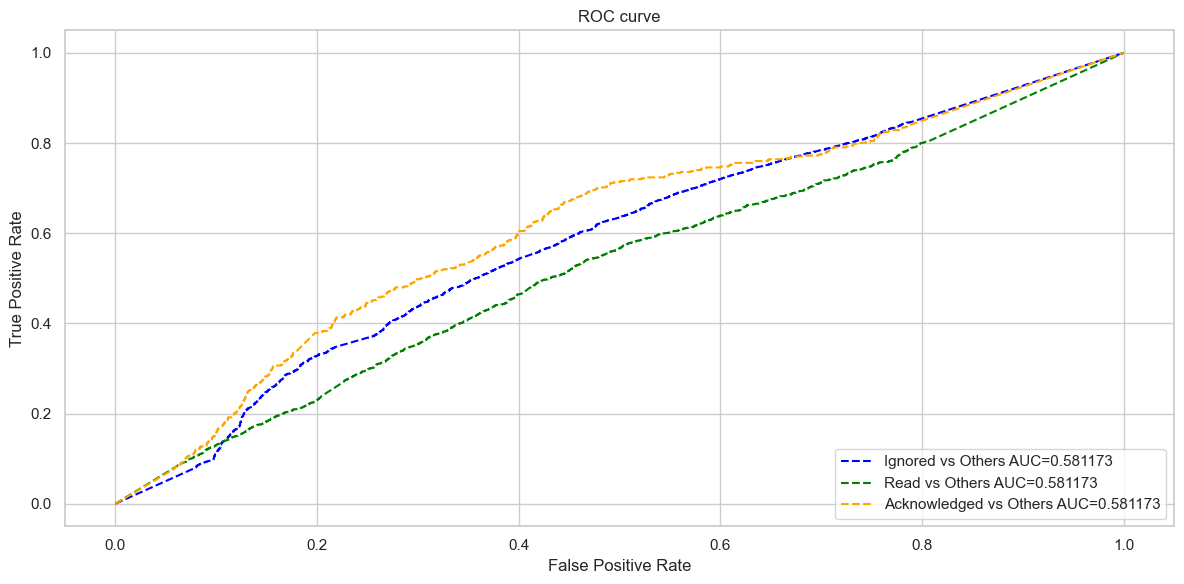

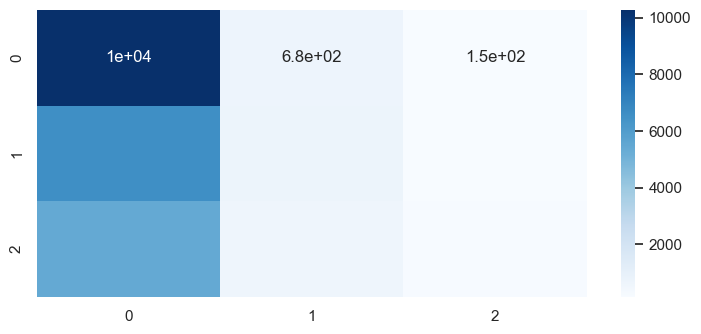

In [79]:
# train data with knn on random undersampling
knn_rus = RandomizedSearchCV(knn, parameters, cv=5, n_iter=10)
knn_rus.fit(X_train_rus, y_train_rus)

# model evaluation
model_evaluation = calculate_model_metrics(knn_rus, X_train_rus, y_train_rus, X_test, y_test)

# add metrics to metrics table
metrics_table.loc[len(metrics_table.index)] = ['KNN', 'RandomUnderSampling',
                                                model_evaluation['Train_Accuracy'], model_evaluation['Train_Precision'],
                                                model_evaluation['Train_Recall'], model_evaluation['Train_F1_Score'],
                                                model_evaluation['Train_ROC_AUC'], model_evaluation['Test_Accuracy'],
                                                model_evaluation['Test_Precision'], model_evaluation['Test_Recall'],
                                                model_evaluation['Test_F1_Score'], model_evaluation['Test_ROC_AUC']]

The best parameters: 
weights=distance
n_neighbors=15
metric=manhattan
leaf_size=20

Best score: 0.7709173921334876

Training Data
Accuracy  : 91.575701 %
Precision : 92.665859 %
Recall    : 91.575701 %
F1 Score  : 91.636646 %
ROC AUC   : 0.990307

Testing Data
Accuracy  : 84.423123 %
Precision : 82.218566 %
Recall    : 84.423123 %
F1 Score  : 83.2625 %
ROC AUC   : 0.568316



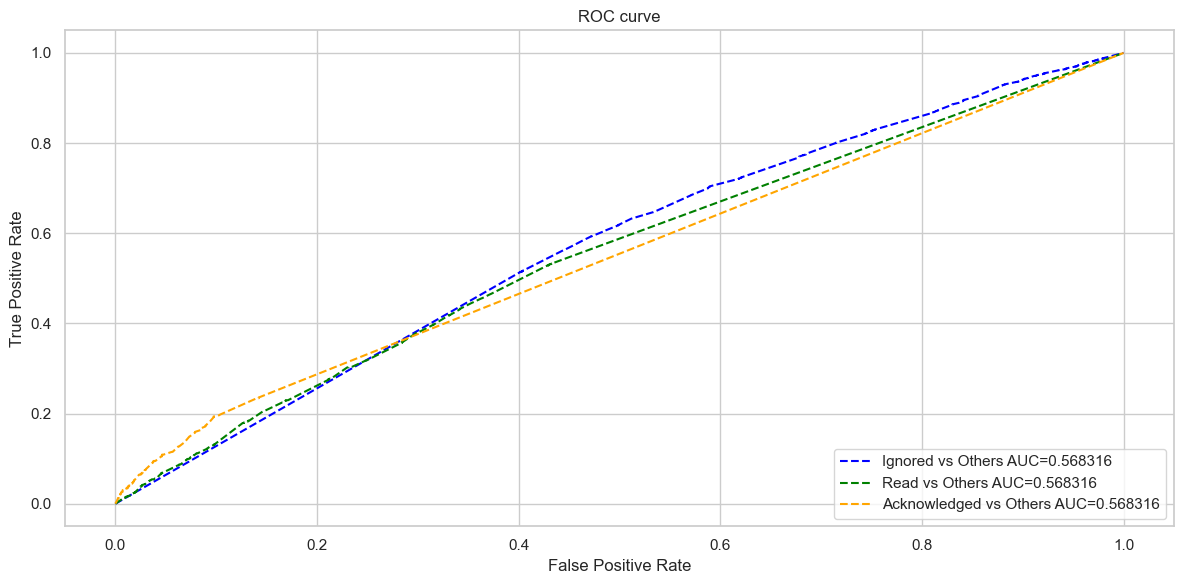

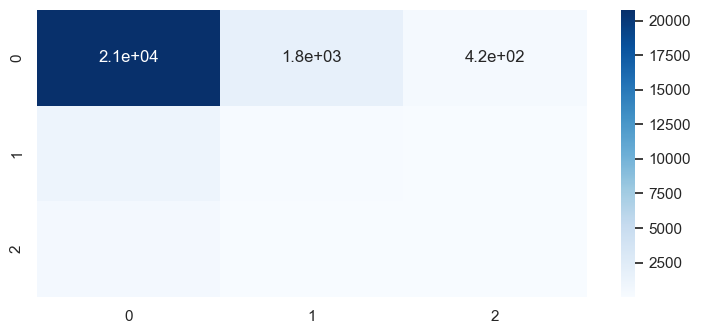

In [80]:
# train data with knn on SMOTE
knn_smote = RandomizedSearchCV(knn, parameters, cv=5, n_iter=10)
knn_smote.fit(X_train_smote, y_train_smote)

# model evaluation
model_evaluation = calculate_model_metrics(knn_smote, X_train_smote, y_train_smote, X_test, y_test)

# add metrics to metrics table
metrics_table.loc[len(metrics_table.index)] = ['KNN', 'SMOTE',
                                                model_evaluation['Train_Accuracy'], model_evaluation['Train_Precision'],
                                                model_evaluation['Train_Recall'], model_evaluation['Train_F1_Score'],
                                                model_evaluation['Train_ROC_AUC'], model_evaluation['Test_Accuracy'],
                                                model_evaluation['Test_Precision'], model_evaluation['Test_Recall'],
                                                model_evaluation['Test_F1_Score'], model_evaluation['Test_ROC_AUC']]

## Model Comparison

In [81]:
# print metrics table
metrics_table

,Model,Sampling,Train_Accuracy,Test_Accuracy,Train_Precision,Test_Precision,Train_Recall,Test_Recall,Train_F1Score,Test_F1Score,Train_ROC_AUC,Test_ROC_AUC
0,Logistic Regression,RandomUnderSampling,47.517271,47.450035,47.517271,47.475437,0.661481,49.524309,85.647100,49.524309,60.584762,0.660855
1,Logistic Regression,SMOTE,47.082609,46.800616,47.082609,46.879785,0.658923,50.524067,85.607264,50.524067,61.548513,0.660772
2,Decision Tree,RandomUnderSampling,44.667530,44.000293,44.667530,43.528465,0.626055,51.068290,84.752264,51.068290,62.546241,0.629290
3,Decision Tree,SMOTE,49.643635,51.824973,49.643635,46.423609,0.680194,42.251875,85.796805,42.251875,54.971121,0.639800
4,Random Forest,RandomUnderSampling,49.222798,49.223299,49.222798,49.175204,0.685836,50.177376,85.903360,50.177376,61.283988,0.665122
5,Random Forest,SMOTE,60.258102,60.322800,60.258102,59.040600,0.783722,57.594937,85.320721,57.594937,67.456335,0.662324
6,XGBoost,RandomUnderSampling,53.259931,53.572669,53.259931,53.226616,0.730208,47.415948,85.936134,47.415948,58.876669,0.664369
7,XGBoost,SMOTE,79.983606,80.307530,79.983606,79.243888,0.931140,86.479078,82.314962,86.479078,84.211642,0.648540
8,LightGBM,RandomUnderSampling,48.639896,49.210745,48.639896,48.661765,0.675106,45.714746,86.306326,45.714746,57.213720,0.665207
9,LightGBM,SMOTE,83.063436,83.220657,83.063436,82.528722,0.947740,86.575828,82.382025,86.575828,84.301783,0.640372


Accuracy, precision, recall or ROC-AUC cannot be used to compare the performance of models since the data is imbalanced. So F1 score should be used to compare different models and find out which one is better. Higher the F1 score, better the model.

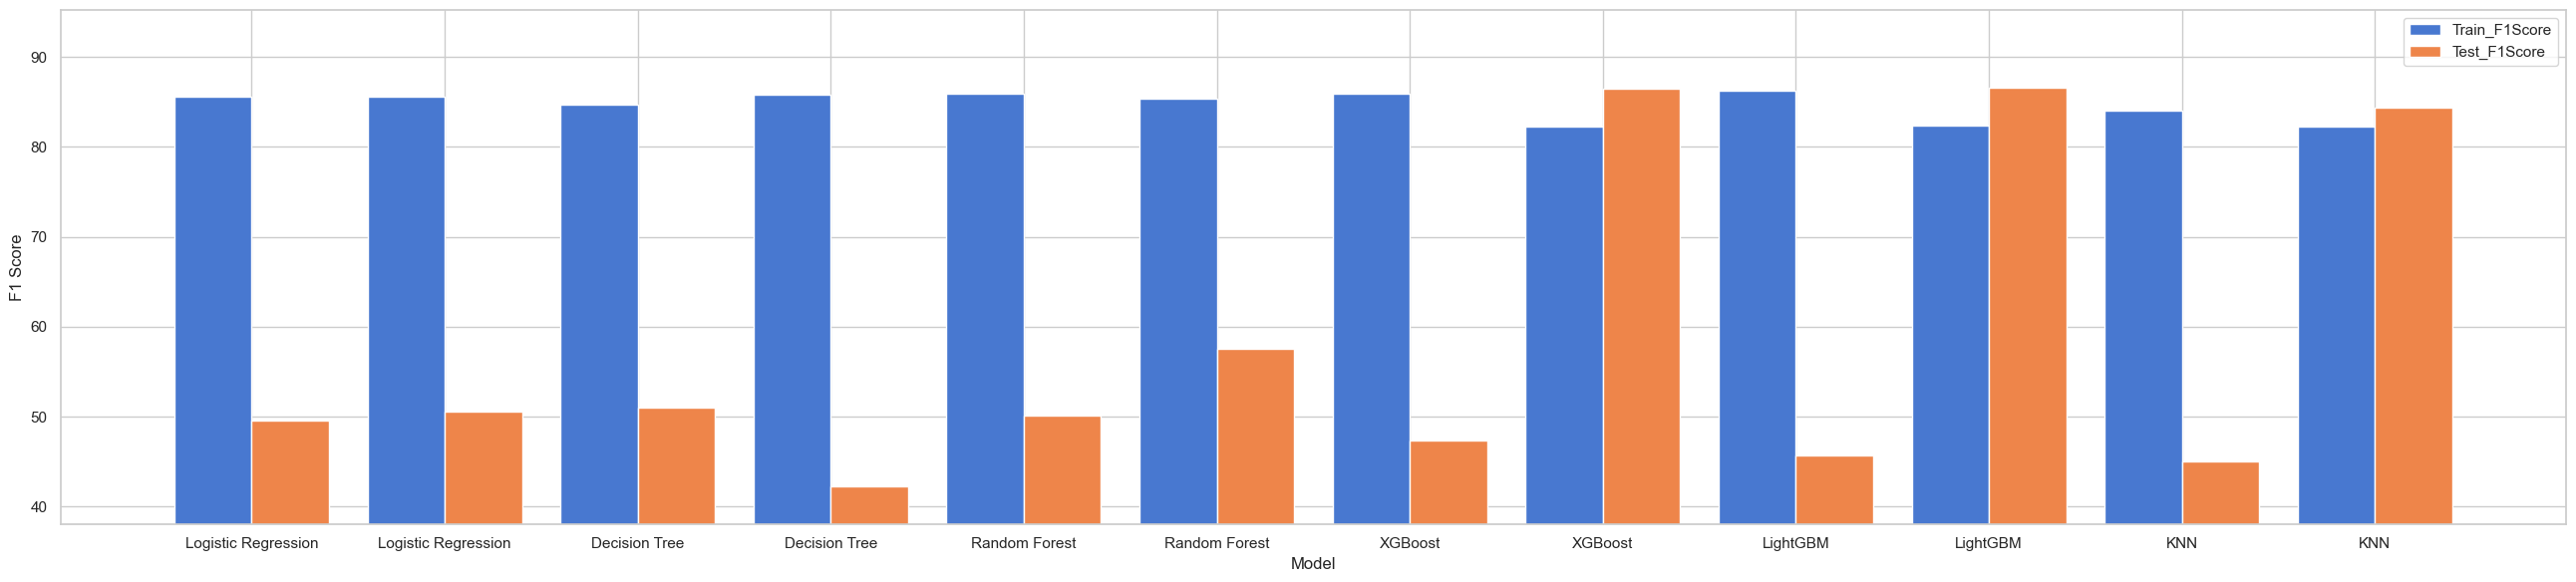

In [82]:
# plot bar graph to show F1 scores
plot_bar_graph_with_three_features(metrics_table, 'Model', 'Train_F1Score', 'Test_F1Score', 'F1 Score')

The model built using LightGBM and XGBoost algorithm with SMOTE dataset have the highest F1 score and also all other models tends to overfit. So we can choose this model. 
Recommended Model: LightGBM with SMOTE

Why?

High Test_F1Score (86.58%)

Best ROC_AUC (84.3) → indicates good class separation

Better generalization compared to XGBoost (less overfitting risk than KNN)

Clean balance across metrics